# Part0 - 前言與資料集準備
   - 組別： 第7組
   - 組員： 廖禹竣、王泓暐、林哲寬
   - 主題： [6] Data Science for COVID-19 (DS4C)
   - 使用的資料集：https://www.kaggle.com/kimjihoo/coronavirusdataset ，其中並不包含SearchTrend及Weather，因為在初步評估時認為其分析的價值較低而捨棄。Time及Case已包含在各資料集中，故不額外進行分析。
   - 分析方法： 視覺化、資料處理、數值性預測


In [1]:
import datetime, time
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


In [2]:
file_names = ['TimeAge.csv', 'TimeProvince.csv', 'Region.csv', 'TimeGender.csv'
              , 'Time.csv', 'Case.csv', 'Weather.csv', 'PatientInfo.csv'
              , 'PatientRoute.csv', 'SeoulFloating.csv', 'SearchTrend.csv', 'Policy.csv']
datasets = []
for f in file_names:
    datasets.append('dataset/' + f)
print(datasets)

['dataset/TimeAge.csv', 'dataset/TimeProvince.csv', 'dataset/Region.csv', 'dataset/TimeGender.csv', 'dataset/Time.csv', 'dataset/Case.csv', 'dataset/Weather.csv', 'dataset/PatientInfo.csv', 'dataset/PatientRoute.csv', 'dataset/SeoulFloating.csv', 'dataset/SearchTrend.csv', 'dataset/Policy.csv']


In [3]:
age = pd.read_csv(datasets[0])
province = pd.read_csv(datasets[1])
region = pd.read_csv(datasets[2])
gender = pd.read_csv(datasets[3])
time = pd.read_csv(datasets[4])
case = pd.read_csv(datasets[5])
weather = pd.read_csv(datasets[6])
patientInfo = pd.read_csv(datasets[7])
patientRoute = pd.read_csv(datasets[8])
sfloat = pd.read_csv(datasets[9])
search = pd.read_csv(datasets[10])
policy = pd.read_csv(datasets[11])


# PartI 區域性層面分析
-----------------------------------
   ## 使用的資料集：
   
 ### Region
  
 資料集說明：
 本資料集的目的在於提供個別的小區域指標性的資料，而並不包括確診數等資訊
 - province : 州
 - city : 州下的次級子區域，也是區域資料的最細項
 - elementary_school_count : 該區域內小學的數量
 - kindergarten_count ： 該區域內幼稚園的數量
 - university_count ： 該區域內大學的數量
 - academy_ratio ：該區域內擁有學院的比例
 - elderly_population_ratio ：該區域內老年人口的比例
 - elderly_alone_ratio ： 該區域內獨居老人人口的比例
 - nursing_home_count ： 該區域內療養院的比例
   
   
###    TimeProvince
資料集說明：
 - date : 該筆資料被記錄的日期
 - time : 該筆資料被記錄的時間
 - province : 該筆資料發生的所在地（州）
 - confirmed : 截止該筆資料的時間為止，該province所累積的確診人數
 - released : 截止該筆資料的時間為止，該province所累積的被釋放的隔離人數
 - deceased : 截止該筆資料的時間為止，該province所累積的死亡人數
 
 
 ### Patient
資料集說明：
- infection_order: 第幾號傳染者，1號代表來自武漢，N號代表是被N-1號傳染
- contact_number:確診者接觸人數
- state:
  - isolated:在醫院中隔離
  - released:康復
  - deceased:死亡
- age:年齡
- disease: TRUE: underlying disease / FALSE: no disease
  
     
 ###    PatientRoute
資料集說明：
 - date : 該筆足跡被記錄的日期
 - province : 該筆足跡發生的所在地（州）
 - city : 該筆足跡發生的所在地（城）
 - type : 前往場所的分類，如無法分類或不詳則以etc表示
 
 
  ## 主要分析法：
 - 視覺化區域內各項數值的概況，從占比、累積趨勢及當日趨勢等三個面向進行討論
 - 研究各大區域疫情的狀況對比，並分群進行進一步的比對
 - 比較各個大區域老年人口、教育水平、獨居老人比例及療養院的比例，並尋求與各區域確診數差異的關聯性
 - 將區域人口及密度等因子加入考量
 - 分析足跡地理位置的分布，並研判與疫情的發展有何相關性
 - 檢視單一病患擁有履歷數的分布
 - 探討前往場所的比例
 - 研究記錄多寡的變動量與確診數變化的關聯性
 - 統計最早足跡時間和確診時間的差距
 

### 1-1 各Province的概況 

### confirmed data(統計至2020-5-14日)

**組成比例**

(-1.1093421156697443,
 1.1004448747722126,
 -1.1055672134023797,
 1.1078921045876047)

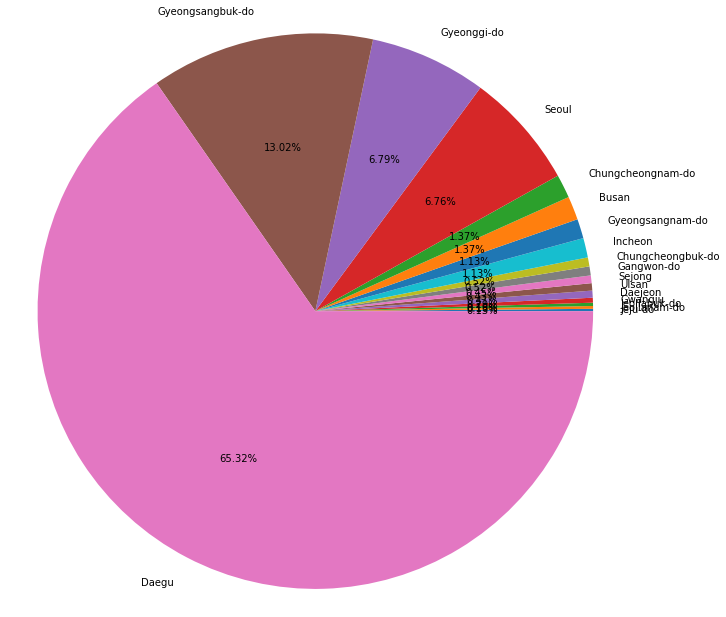

In [4]:
# last day confirmed percentage
order = pd.DataFrame()
order['province'] = province['province'].unique()
size = list(province.loc[province['date'] == '2020-05-14', 'confirmed'])
order['size'] = size
order = order.sort_values(by=['size'])

fig, ax = plt.subplots(figsize=(11,11))
ax.pie(order['size'], labels=order['province'], autopct='%.2f%%')
plt.axis('equal')

分析結果：從確診數的區域佔比讓我們初步認知到爆發新天地教會事件的大邱是最嚴重的，與慶尚北道加起來就佔了全部確診的將近五分之四。接下來除了京畿道和首爾次之之外，其他的省分感染情況相對的並不明顯。

**累積性成長趨勢**

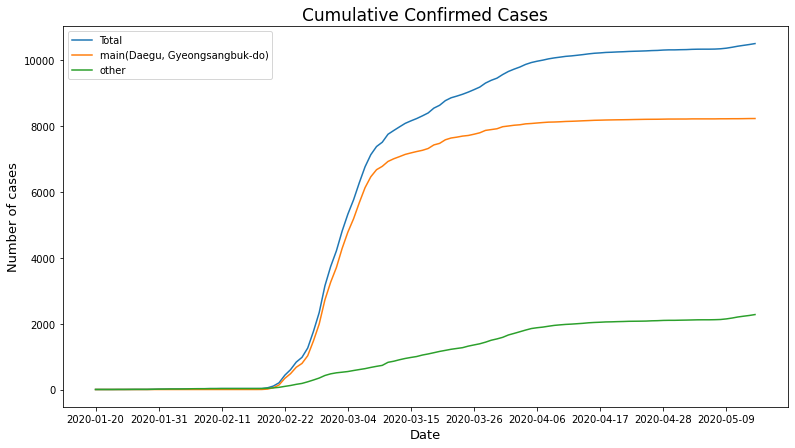

In [5]:
# Cumulative Confirmed Cases
# Total
total_list = province.groupby('date').sum().confirmed
fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Cumulative Confirmed Cases', fontsize=17)
ax.set_xlabel('Date', size=13)
ax.set_ylabel('Number of cases', size=13)
plt.plot(province.date.unique(), province.groupby('date').sum().confirmed , label='Total')
# ax.set_xticks(ax.get_xticks()[::11])

# main
loc = province[(province.province=='Daegu') | (province.province=='Gyeongsangbuk-do')].groupby('date').sum().confirmed
# fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Cumulative Confirmed Cases', fontsize=17)
ax.set_xlabel('Date', size=13)
ax.set_ylabel('Number of cases', size=13)
plt.plot(province.date.unique(), loc, label='main(Daegu, Gyeongsangbuk-do)')
# ax.set_xticks(ax.get_xticks()[::11])

# other
loc = province[(province.province!='Daegu') & (province.province!='Gyeongsangbuk-do')].groupby('date').sum().confirmed
# fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Cumulative Confirmed Cases', fontsize=17)
ax.set_xlabel('Date', size=13)
ax.set_ylabel('Number of cases', size=13)
plt.plot(province.date.unique(), loc, label='other')
ax.set_xticks(ax.get_xticks()[::11])

plt.legend(loc='upper left')

分析結果：2月底特定地區大量指數型爆發，而其他地區線性增長，造成總確診數跟著指數型爆發。最後隨著疫情的平緩，總確診數上揚與其他地區確診數上揚較為相關。

**單日確診成長趨勢**

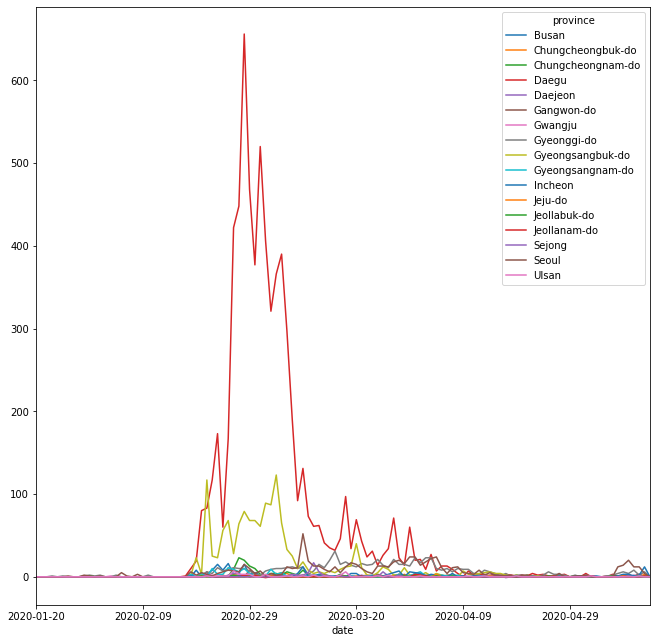

In [6]:
# daily confirmed
for title in province['province'].unique():
    day = province.loc[province['province']==title, 'confirmed']
    province.loc[province['province']==title, 'daily_confirmed'] = day.shift(-1) - day

province.groupby(['date','province'])['daily_confirmed'].sum() .unstack('province', fill_value=0).plot(legend=True, figsize=(11,11))

分析結果：每日確診數，高峰期後地區增長率相差不大。最後首爾地區每日確診數突然爆發與上圖累計確診數相關。

### deceased data(統計至2020-5-14日)

**組成比例**

(-1.1139873190707088,
 1.1006660705941442,
 -1.1095146451338227,
 1.1240400815671001)

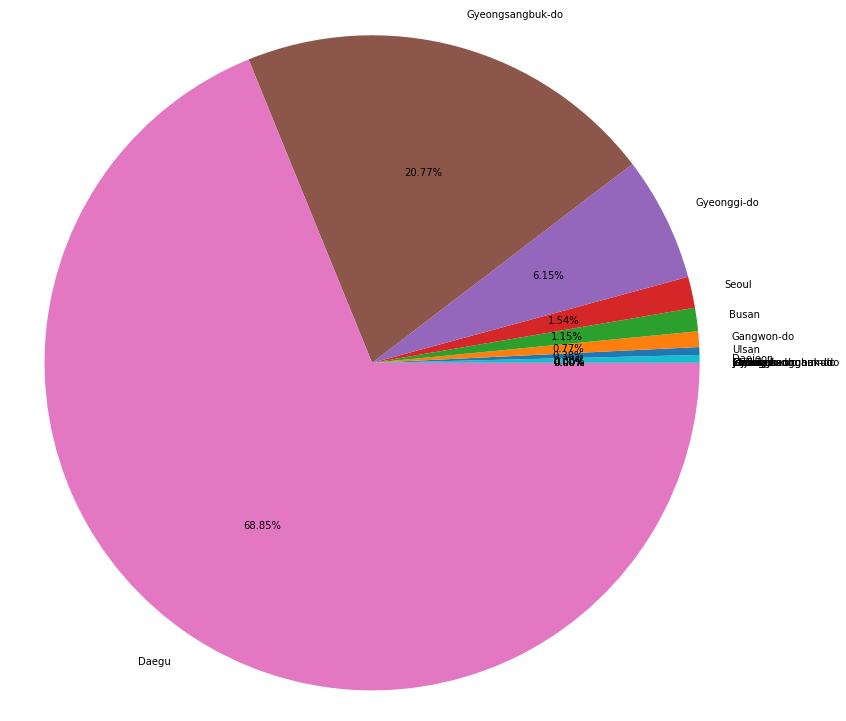

In [7]:
order = pd.DataFrame()
order['province'] = province['province'].unique()
size = list(province.loc[province['date'] == '2020-05-14', 'deceased'])
order['size'] = size
order = order.sort_values(by=['size'])

fig, ax = plt.subplots(figsize=(13,13))
ax.pie(order['size'], labels=order['province'], autopct='%.2f%%')
plt.axis('equal')

分析結果：大致上各區域的分布情形與確診數差不多，畢竟得病的人越多也會有越多人死亡。值得注意的是京畿道的比例增加，而首爾的比例顯著減少，或許是醫療環境不同或有其他的因素在。

**累積性成長趨勢**

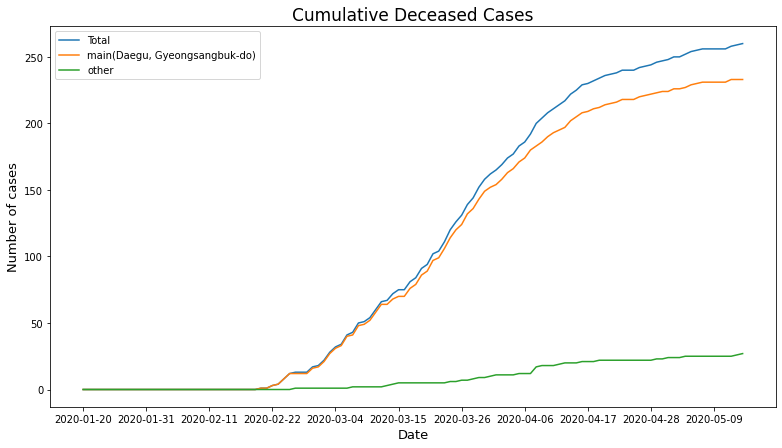

In [8]:
# Cumulative deceased Cases
# Total
total_list = province.groupby('date').sum().deceased
fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Cumulative Deceased Cases', fontsize=17)
ax.set_xlabel('Date', size=13)
ax.set_ylabel('Number of cases', size=13)
plt.plot(province.date.unique(), province.groupby('date').sum().deceased , label='Total')
# ax.set_xticks(ax.get_xticks()[::11])

# main
loc = province[(province.province=='Daegu') | (province.province=='Gyeongsangbuk-do')].groupby('date').sum().deceased
# fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Cumulative Deceased Cases', fontsize=17)
ax.set_xlabel('Date', size=13)
ax.set_ylabel('Number of cases', size=13)
plt.plot(province.date.unique(), loc, label='main(Daegu, Gyeongsangbuk-do)')
# ax.set_xticks(ax.get_xticks()[::11])

# other
loc = province[(province.province!='Daegu') & (province.province!='Gyeongsangbuk-do')].groupby('date').sum().deceased
# fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Cumulative Deceased Cases', fontsize=17)
ax.set_xlabel('Date', size=13)
ax.set_ylabel('Number of cases', size=13)
plt.plot(province.date.unique(), loc, label='other')
ax.set_xticks(ax.get_xticks()[::11])

plt.legend(loc='upper left')

分析結果：總死亡數幾乎隨著主要爆發地區趨勢增長，而最後的上揚同樣是其他地區影響。

**單日死亡成長趨勢**

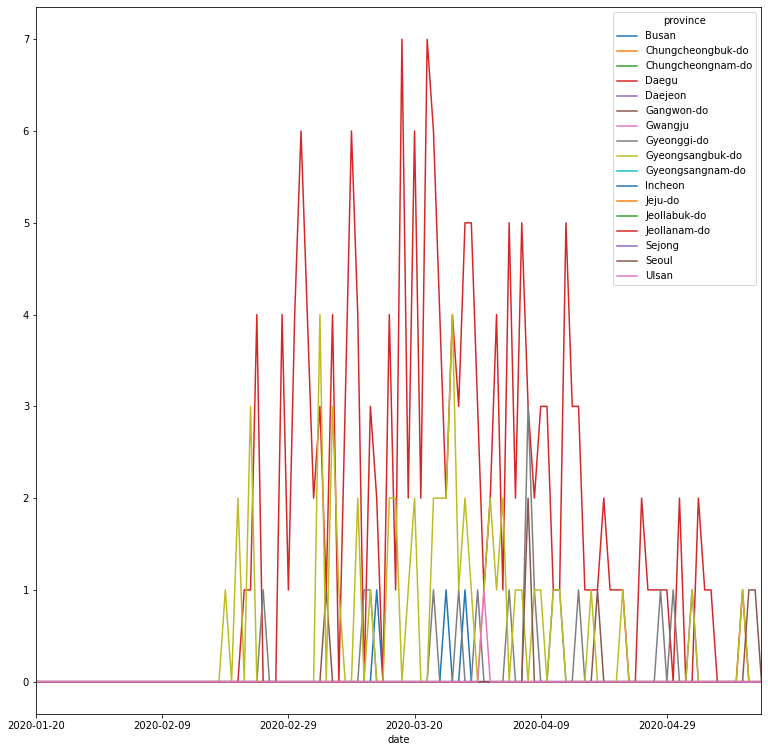

In [9]:

# daily deceased
for title in province['province'].unique():
    day = province.loc[province['province']==title, 'deceased']
    province.loc[province['province']==title, 'daily_deceased'] = day.shift(-1) - day

province.groupby(['date','province'])['daily_deceased'].sum() .unstack('province', fill_value=0).plot(legend=True, figsize=(13,13))

分析結果：最後死亡數上揚和病情爆發的首爾地區有關聯。此外可以從各線段與紫色水平線的交點看出感染情況嚴重的區域死亡數，該日每人死亡的頻率也較低。並不是累積在同一時間附近死亡的模式。

### release data(統計至2020-5-14日)

**組成比例**

(-1.1030120209484613,
 1.1001434295689743,
 -1.1019600087418704,
 1.1088019997781309)

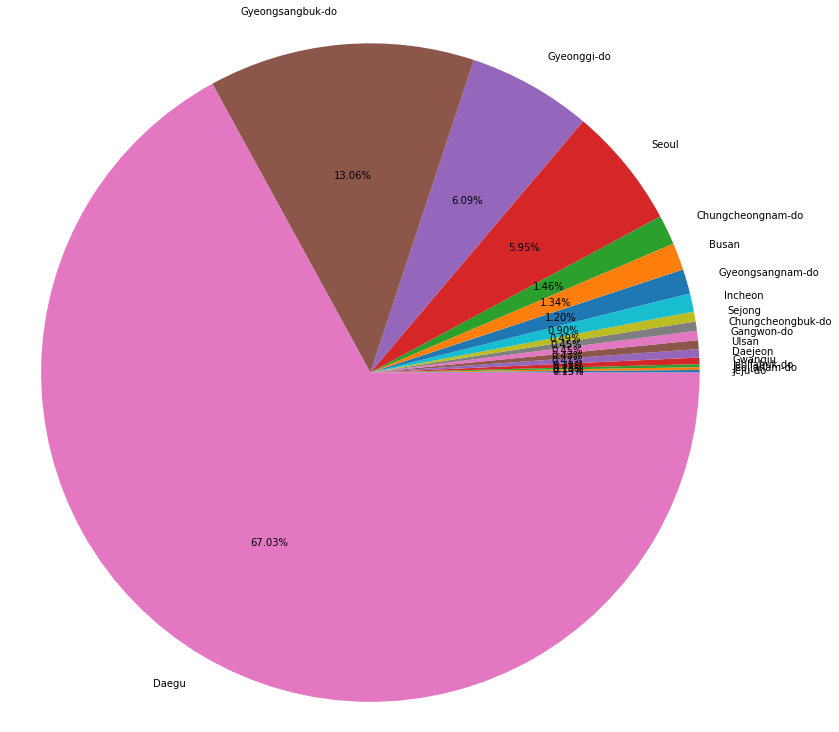

In [10]:
order = pd.DataFrame()
order['province'] = province['province'].unique()
size = list(province.loc[province['date'] == '2020-05-14', 'released'])
order['size'] = size
order = order.sort_values(by=['size'])

fig, ax = plt.subplots(figsize=(13,13))
ax.pie(order['size'], labels=order['province'], autopct='%.2f%%')
plt.axis('equal')

分析結果：隔離釋放人數也是爆發地區占多數，可能與爆發地區大規模篩檢有關。比起死亡比例，被釋放的比例和確診比例較為相似。

**累積性成長趨勢**

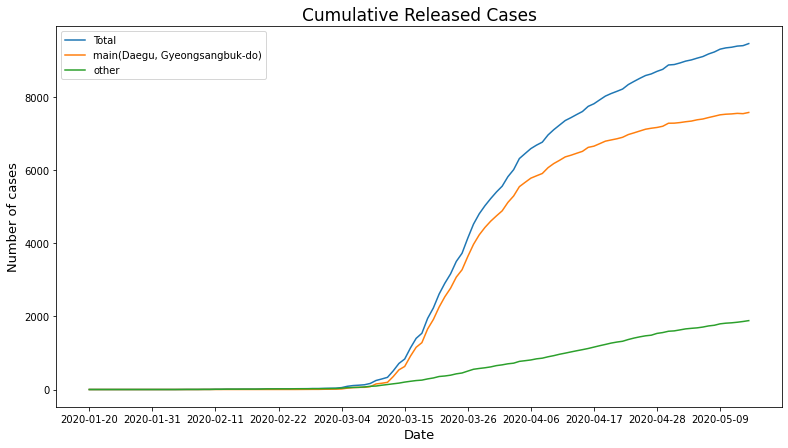

In [11]:
# Cumulative released Cases
# Total
total_list = province.groupby('date').sum().released
fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Cumulative Released Cases', fontsize=17)
ax.set_xlabel('Date', size=13)
ax.set_ylabel('Number of cases', size=13)
plt.plot(province.date.unique(), province.groupby('date').sum().released , label='Total')
# ax.set_xticks(ax.get_xticks()[::11])

# main
loc = province[(province.province=='Daegu') | (province.province=='Gyeongsangbuk-do')].groupby('date').sum().released
# fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Cumulative Released Cases', fontsize=17)
ax.set_xlabel('Date', size=13)
ax.set_ylabel('Number of cases', size=13)
plt.plot(province.date.unique(), loc, label='main(Daegu, Gyeongsangbuk-do)')
# ax.set_xticks(ax.get_xticks()[::11])

# other
loc = province[(province.province!='Daegu') & (province.province!='Gyeongsangbuk-do')].groupby('date').sum().released
# fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Cumulative Released Cases', fontsize=17)
ax.set_xlabel('Date', size=13)
ax.set_ylabel('Number of cases', size=13)
plt.plot(province.date.unique(), loc, label='other')
ax.set_xticks(ax.get_xticks()[::11])

plt.legend(loc='upper left')

分析結果：和前面兩個一樣幾乎是主要爆發區主宰整體趨勢的傾向。

**單日釋放數成長趨勢**

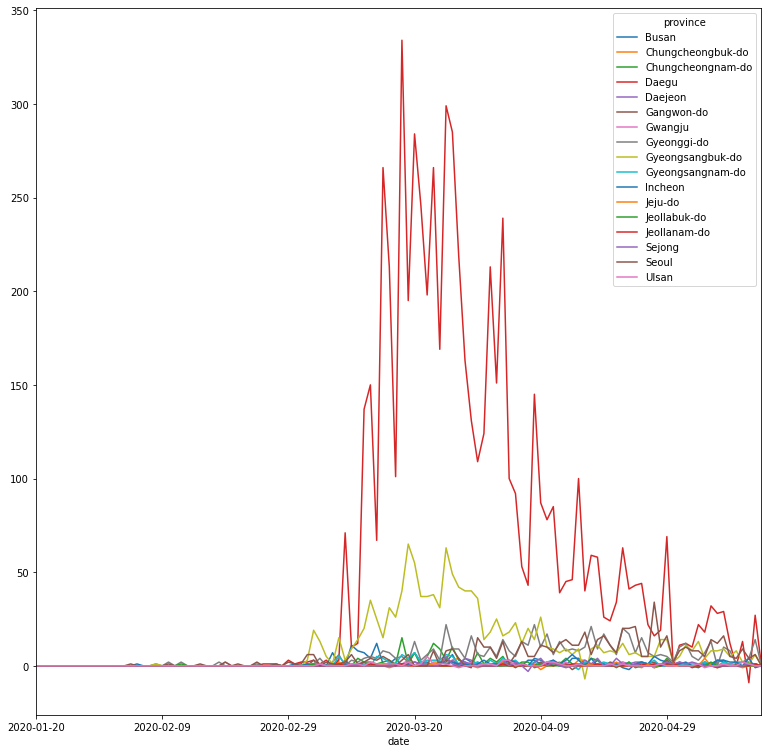

In [12]:

# daily released
for title in province['province'].unique():
    day = province.loc[province['province']==title, 'released']
    province.loc[province['province']==title, 'daily_released'] = day.shift(-1) - day

province.groupby(['date','province'])['daily_released'].sum() .unstack('province', fill_value=0).plot(legend=True, figsize=(13,13))

分析結果：表為每日從隔離中釋放人數，其中負數代表復陽的情況或是統計錯誤或是該病患死亡，單純從時間上不得而知。

### 以分群的方式觀察各地區感染情況

從前面的部分可以非常懸殊的可以大邱就是被感染最嚴重的區域。但由於它的一枝獨秀，其它區域的結果都被擠扁了。我們把區域分為感染嚴重和不嚴重的兩類，以更好地觀察它們之間的差異。

**嚴重區域**

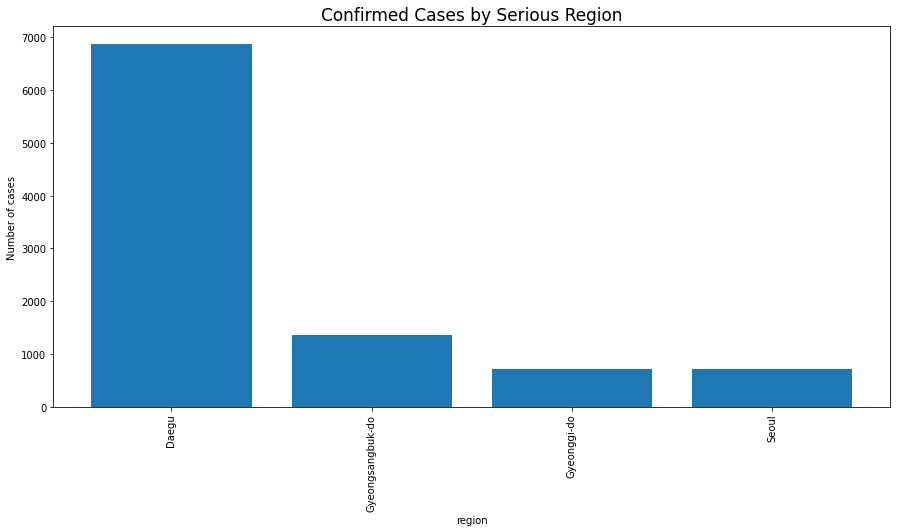

In [13]:
df_province = province
df_province_max = df_province.groupby('province').max()
df_province_max = df_province_max.sort_values(by='confirmed',ascending=False)[0:4]

fig, ax = plt.subplots(figsize=(15, 7))
plt.title('Confirmed Cases by Serious Region', fontsize=17)
plt.xticks(rotation=90)
plt.bar(df_province_max.index
        , df_province_max.confirmed
         )
plt.xlabel('region')
plt.ylabel('Number of cases')
plt.show()

**不嚴重區域**

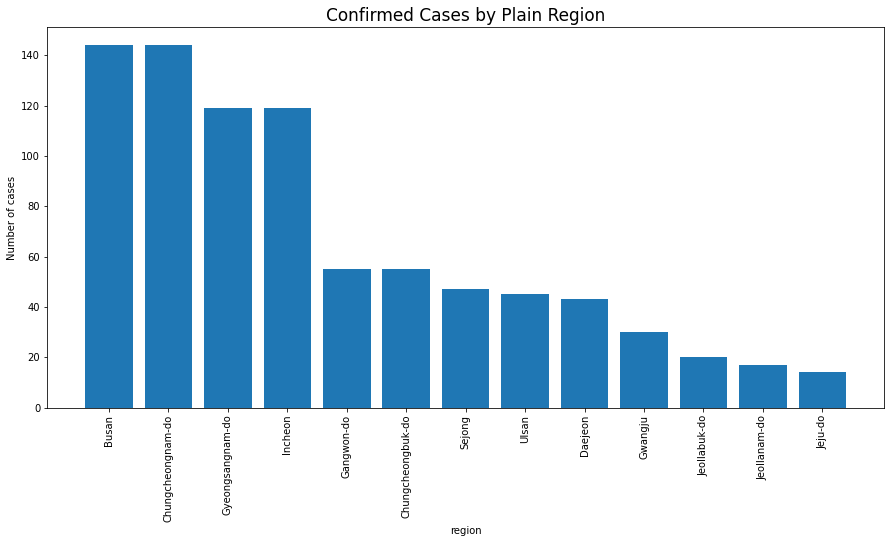

In [14]:
df_province_max = df_province.groupby('province').max()
df_province_max = df_province_max.sort_values(by='confirmed',ascending=False)[4:]

fig, ax = plt.subplots(figsize=(15, 7))
plt.title('Confirmed Cases by Plain Region', fontsize=17)
plt.xticks(rotation=90)
plt.bar(df_province_max.index
        , df_province_max.confirmed
         )
plt.xlabel('region')
plt.ylabel('Number of cases')
plt.show()

分析結果：比較不嚴重的區域又可分成兩群的樣子。接下來將藉由網路(http://index.go.kr/potal/main/EachDtlPageDetail.do?idx_cd=1007) 查到的區域人口以及面積的資訊來算出人口密度，來判斷區域稠密度與疫情的關聯性。

### 人口與各地區感染情況之關聯性

**人口密度**

In [15]:
pop_dense = df_province.groupby('province').max()


pop_dense = pop_dense.sort_values(by='confirmed',ascending=False)
# density = 千人 / km²
pop_dense['density'] = [2773, 141, 1279, 16034, 265, 4416
                        , 318, 653, 2764, 1088, 219, 90
                        , 2813, 2980, 226, 145, 353]


pop_dense

,date,time,confirmed,released,deceased,daily_confirmed,daily_deceased,daily_released,density
province,,,,,,,,,
Daegu,2020-05-14,16,6865,6349,179,656.0,7.0,334.0,2773
Gyeongsangbuk-do,2020-05-14,16,1368,1237,54,123.0,4.0,65.0,141
Gyeonggi-do,2020-05-14,16,714,577,16,31.0,3.0,22.0,1279
Seoul,2020-05-14,16,711,564,4,52.0,2.0,34.0,16034
Busan,2020-05-14,16,144,127,3,16.0,1.0,12.0,265
Chungcheongnam-do,2020-05-14,16,144,138,0,23.0,0.0,15.0,4416
Gyeongsangnam-do,2020-05-14,16,119,114,0,11.0,0.0,7.0,318
Incheon,2020-05-14,16,119,86,0,12.0,0.0,6.0,653
Gangwon-do,2020-05-14,16,55,43,2,8.0,1.0,3.0,2764


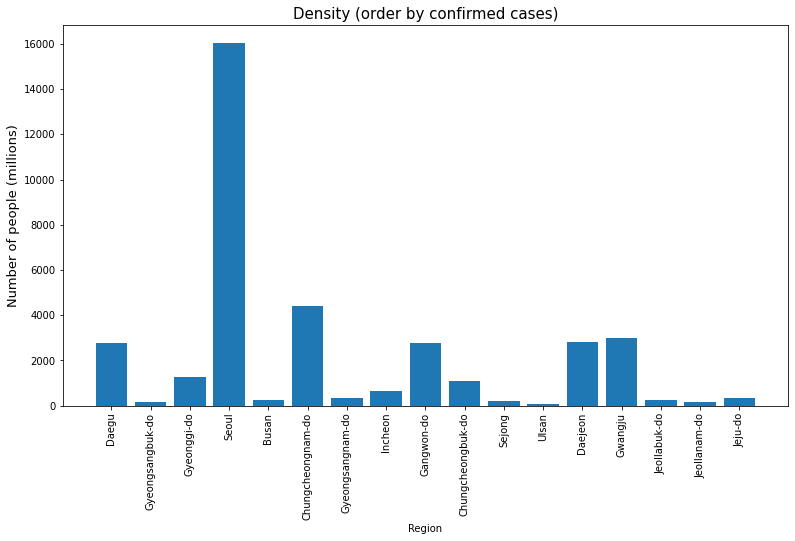

In [16]:
fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Density (order by confirmed cases)', fontsize=15)
plt.bar(pop_dense.index, pop_dense.density)
plt.xticks(rotation=90)
plt.xlabel('Region')
plt.ylabel('Number of people (millions)', size=13)
plt.show()

分析結果：剔除掉一些特例的話，明顯是一種密度越高致病性也越高的微弱正相關性。特別是作為指標性的首爾。不過那也可能是人口數的放大效應，而非密度。因此接下來將研究一下各區域人口數及傳染性的關係。

**人口數**

In [17]:
pop_dense['population'] = np.divide(
    [2450, 2674, 13031, 9705, 2180, 3400
     , 3356, 304, 2939, 1154, 1619, 1521
     , 1518, 1493, 1820, 1790, 653]
    , 1000 # thousand to million
)

pop_dense

,date,time,confirmed,released,deceased,daily_confirmed,daily_deceased,daily_released,density,population
province,,,,,,,,,,
Daegu,2020-05-14,16,6865,6349,179,656.0,7.0,334.0,2773,2.450
Gyeongsangbuk-do,2020-05-14,16,1368,1237,54,123.0,4.0,65.0,141,2.674
Gyeonggi-do,2020-05-14,16,714,577,16,31.0,3.0,22.0,1279,13.031
Seoul,2020-05-14,16,711,564,4,52.0,2.0,34.0,16034,9.705
Busan,2020-05-14,16,144,127,3,16.0,1.0,12.0,265,2.180
Chungcheongnam-do,2020-05-14,16,144,138,0,23.0,0.0,15.0,4416,3.400
Gyeongsangnam-do,2020-05-14,16,119,114,0,11.0,0.0,7.0,318,3.356
Incheon,2020-05-14,16,119,86,0,12.0,0.0,6.0,653,0.304
Gangwon-do,2020-05-14,16,55,43,2,8.0,1.0,3.0,2764,2.939


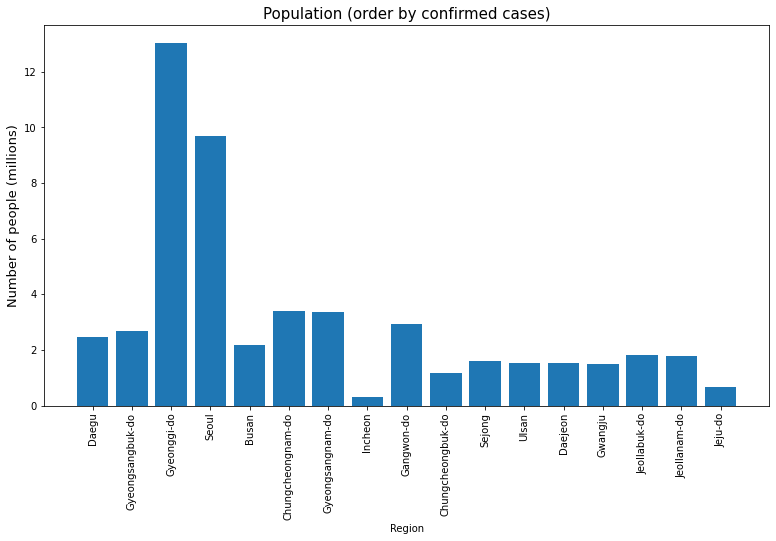

In [18]:
fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Population (order by confirmed cases)', fontsize=15)
plt.bar(pop_dense.index, pop_dense.population)
plt.xticks(rotation=90)
plt.xlabel('Region')
plt.ylabel('Number of people (millions)', size=13)
plt.show()

分析結果：區域人口就滿符合人越多生病的人也會越多的特性。因此我們可以斷言首爾會有那麼多的確診數比起密度，跟人口數比較有關係。

### 1-2 區域間的各項指標比較

**概覽**

In [19]:
df_region = region

display(df_region.head(5).append(df_region.tail(5)).T)

,0,1,2,3,4,239,240,241,242,243
code,10000,10010,10020,10030,10040,61160,61170,61180,70000,80000
province,Seoul,Seoul,Seoul,Seoul,Seoul,Gyeongsangnam-do,Gyeongsangnam-do,Gyeongsangnam-do,Jeju-do,Korea
city,Seoul,Gangnam-gu,Gangdong-gu,Gangbuk-gu,Gangseo-gu,Haman-gun,Hamyang-gun,Hapcheon-gun,Jeju-do,Korea
latitude,37.567,37.5184,37.5305,37.6399,37.5512,35.2725,35.5205,35.5667,33.4889,37.567
longitude,126.978,127.047,127.124,127.026,126.85,128.407,127.725,128.166,126.5,126.978
elementary_school_count,607,33,27,14,36,16,13,17,113,6087
kindergarten_count,830,38,32,21,56,20,12,15,123,8837
university_count,48,0,0,0,1,0,0,0,4,340
academy_ratio,1.44,4.18,1.54,0.67,1.17,1.19,1.01,0.71,1.53,1.56
elderly_population_ratio,15.38,13.17,14.55,19.49,14.39,23.74,32.65,38.44,15.1,15.67


In [20]:
print('Province 總數:', len(df_region.province.unique()))
print(df_region.province.unique())

Province 總數: 18
['Seoul' 'Busan' 'Daegu' 'Gwangju' 'Incheon' 'Daejeon' 'Ulsan' 'Sejong'
 'Gyeonggi-do' 'Gangwon-do' 'Chungcheongbuk-do' 'Chungcheongnam-do'
 'Jeollabuk-do' 'Jeollanam-do' 'Gyeongsangbuk-do' 'Gyeongsangnam-do'
 'Jeju-do' 'Korea']


南韓一共有十七個州，其中最後一個「Korea」為全局的統計資訊

In [21]:
df_region[df_region.province=='Korea'].T

,243
code,80000
province,Korea
city,Korea
latitude,37.567
longitude,126.978
elementary_school_count,6087
kindergarten_count,8837
university_count,340
academy_ratio,1.56
elderly_population_ratio,15.67


### 老年人口

**分布情形**

In [22]:
region_elder = pd.DataFrame()
region_elder['elder_ratio'] = df_region[df_region.province!='Korea'].groupby('province').mean().elderly_population_ratio
region_elder = region_elder.sort_values(ascending=False, by = 'elder_ratio')
region_elder

,elder_ratio
province,
Jeollanam-do,28.142174
Gyeongsangbuk-do,27.556250
Jeollabuk-do,27.470667
Gyeongsangnam-do,24.749474
Chungcheongnam-do,23.844375
Chungcheongbuk-do,23.192500
Gangwon-do,22.890526
Busan,19.357647
Daegu,17.031111


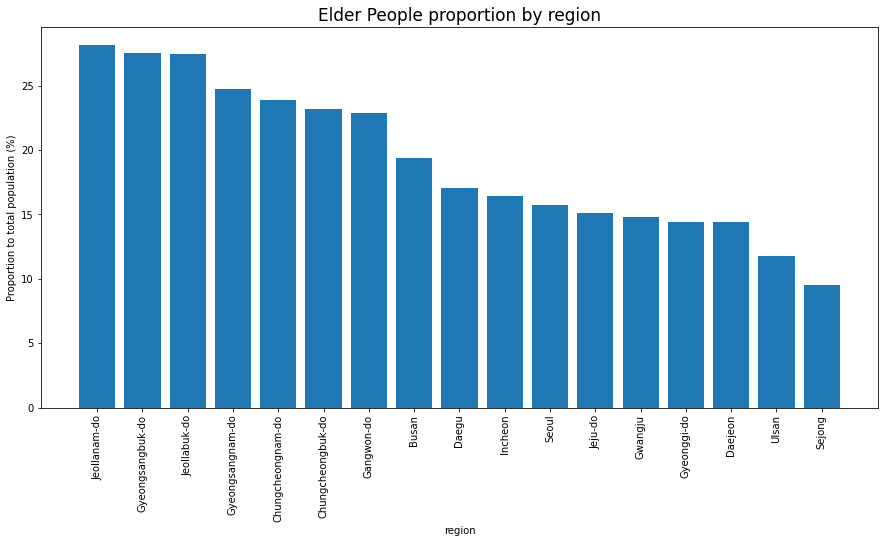

In [23]:
fig, ax = plt.subplots(figsize=(15, 7))
plt.title('Elder People proportion by region', fontsize=17)
plt.xticks(rotation=90)
plt.bar(region_elder.index, region_elder.elder_ratio)
plt.xlabel('region')
plt.ylabel('Proportion to total population (%)')
plt.show()

分析結果：上面是各區域的老人分布情形，通常大都會區的老人比例會較低，由此可推測各個區域的都市化程度。或是該都市的工業化程度也會影響老人的比例。例如倒數第二的蔚山即為韓國著名的工業區。

**與確診數之關聯**

接下來將對各區域以確診數的方式排序，以確認兩者之間的相關性。排序的依據是從前面觀察到的結果

In [24]:
df_province = province
display(df_province.head(5).append(df_province.tail(5)))

,date,time,province,confirmed,released,deceased,daily_confirmed,daily_deceased,daily_released
0,2020-01-20,16,Seoul,0,0,0,0.0,0.0,0.0
1,2020-01-20,16,Busan,0,0,0,0.0,0.0,0.0
2,2020-01-20,16,Daegu,0,0,0,0.0,0.0,0.0
3,2020-01-20,16,Incheon,1,0,0,0.0,0.0,0.0
4,2020-01-20,16,Gwangju,0,0,0,0.0,0.0,0.0
1967,2020-05-14,0,Jeollabuk-do,20,14,0,NaN,NaN,NaN
1968,2020-05-14,0,Jeollanam-do,17,13,0,NaN,NaN,NaN
1969,2020-05-14,0,Gyeongsangbuk-do,1368,1237,54,NaN,NaN,NaN
1970,2020-05-14,0,Gyeongsangnam-do,119,114,0,NaN,NaN,NaN
1971,2020-05-14,0,Jeju-do,14,12,0,NaN,NaN,NaN


In [25]:
df_province_max = df_province.groupby('province').max()
df_province_max = df_province_max.sort_values(by='confirmed',ascending=False)
confirm_order = list(df_province_max.index)


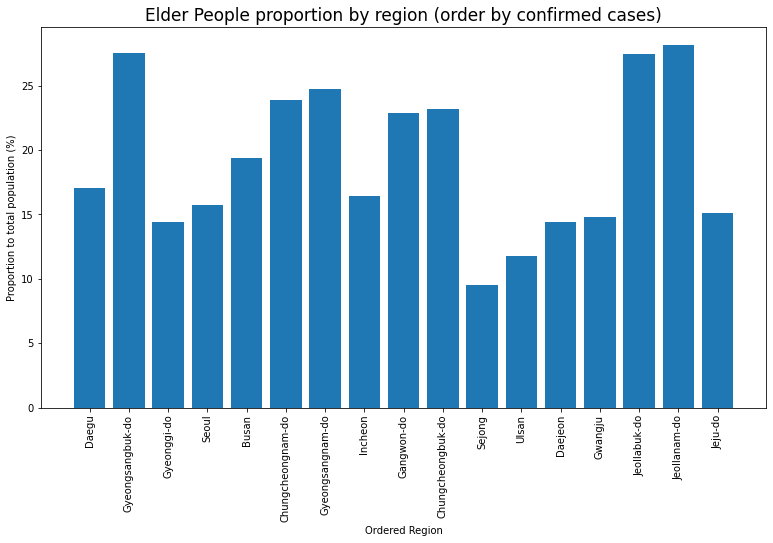

In [26]:
region_elder_order = pd.DataFrame()
for order in confirm_order:
    new_row = {'province':order, 'elder_ratio':region_elder.at[order,'elder_ratio']}
    region_elder_order = region_elder_order.append(new_row,ignore_index=True)
region_elder_order = region_elder_order[['province','elder_ratio']]


fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Elder People proportion by region (order by confirmed cases)', fontsize=17)
plt.xticks(rotation=90)
plt.xlabel('Ordered Region')
plt.ylabel('Proportion to total population (%)')
plt.bar(region_elder_order.province, region_elder_order.elder_ratio)
plt.show()

分析結果：一如全國性的觀察，老人的確診率並未擁有支配性的地位，導致各區域間的長青人口比率以及確診率很明顯的並無相關性。下面將以死亡率重新排序，來看看是否會有不一樣的結果。

**與死亡數之關聯**

In [27]:
df_province_max = df_province.groupby('province').max()
df_province_max = df_province_max.sort_values(by='deceased',ascending=False)
deceased_rank = list(df_province_max.index)


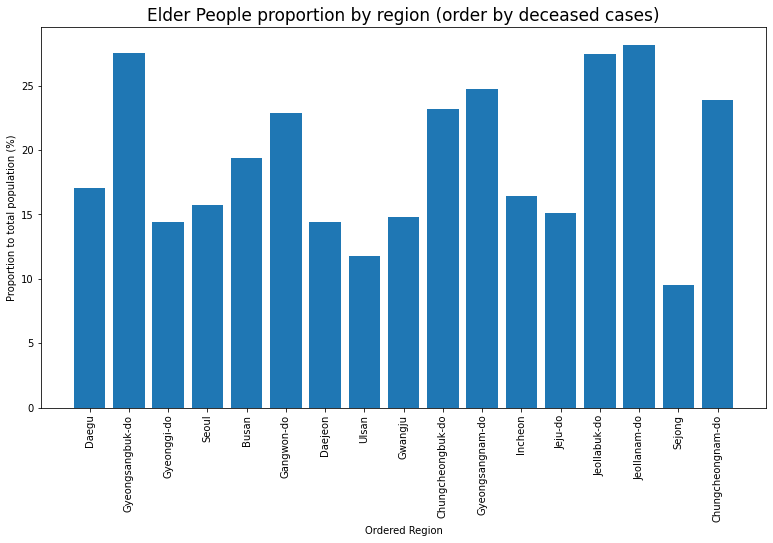

In [28]:
region_elder_order = pd.DataFrame()
death_order = deceased_rank
for order in death_order:
    new_row = {'province':order, 'elder_ratio':region_elder.at[order,'elder_ratio']}
    region_elder_order = region_elder_order.append(new_row,ignore_index=True)
region_elder_order = region_elder_order[['province','elder_ratio']]


fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Elder People proportion by region (order by deceased cases)', fontsize=17)
plt.xticks(rotation=90)
plt.xlabel('Ordered Region')
plt.ylabel('Proportion to total population (%)')
plt.bar(region_elder_order.province, region_elder_order.elder_ratio)
plt.show()


分析結果：如圖，以死亡率排序給予的提示也並不明顯，而且有很多區域都是零，參考性並不明確，本節剩下的部分將不再研究死亡率。接著從各地區的教育程度著手。

### 教育情形

**各地教育情形對比**

In [29]:
region_educate = pd.DataFrame()
region_educate['academy_ratio'] = df_region[df_region.province!='Korea'].groupby('province').mean().academy_ratio
region_educate = region_educate.sort_values(ascending=False, by = 'academy_ratio')
region_educate

,academy_ratio
province,
Gwangju,2.473333
Ulsan,2.111667
Sejong,1.780000
Daegu,1.713333
Jeju-do,1.530000
Daejeon,1.425000
Gyeonggi-do,1.420625
Gyeongsangnam-do,1.363158
Seoul,1.360000


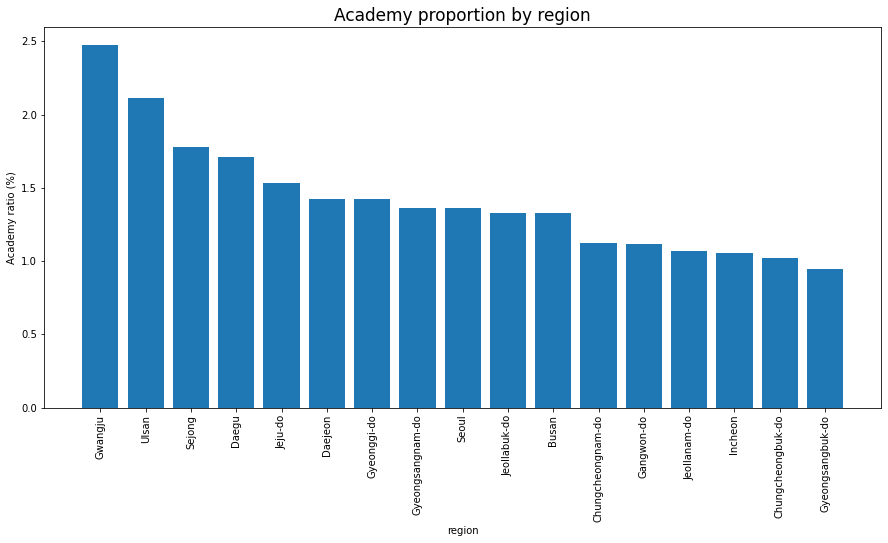

In [30]:
fig, ax = plt.subplots(figsize=(15, 7))
plt.title('Academy proportion by region', fontsize=17)
plt.xticks(rotation=90)
plt.bar(region_educate.index, region_educate.academy_ratio)
plt.xlabel('region')
plt.ylabel('Academy ratio (%)')
plt.show()

分析結果：排名的依據是各區所有次級區域academy ratio的平均。作為首都並且擁有局部最大值的首爾因為有而很多數值小的區域而被拖累，只排在中段。但從數據變化量可看出大家的差距都不會很多。

**與確診數之關聯**

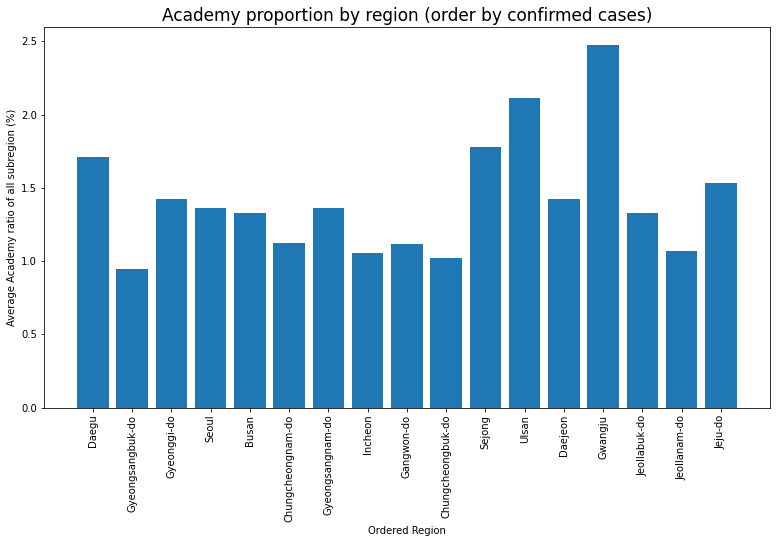

In [31]:
region_edu_order = pd.DataFrame()
for order in confirm_order:
    new_row = {'province':order, 'academy_ratio':region_educate.at[order,'academy_ratio']}
    region_edu_order  = region_edu_order .append(new_row,ignore_index=True)
region_edu_order  = region_edu_order [['province','academy_ratio']]


fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Academy proportion by region (order by confirmed cases)', fontsize=17)
plt.xticks(rotation=90)
plt.xlabel('Ordered Region')
plt.ylabel('Average Academy ratio of all subregion (%)')
plt.bar(region_edu_order.province, region_edu_order.academy_ratio)
plt.show()


分析結果：排除作為outlier的大邱後，可以注意到某些平均教育比例較高的區域的確屬於比較不嚴重的區域。像是光州。或許人民的教育水平還是有一點點的影響。

### 獨居老人層面

**各地獨居老人情形對比**

In [32]:
region_alone = pd.DataFrame()
region_alone['alone_ratio'] = df_region[df_region.province!='Korea'].groupby('province').mean().elderly_alone_ratio
region_alone = region_alone.sort_values(ascending=False, by = 'alone_ratio')
region_alone

,alone_ratio
province,
Jeollanam-do,17.030435
Jeollabuk-do,15.533333
Gyeongsangbuk-do,15.133333
Gyeongsangnam-do,14.721053
Chungcheongbuk-do,11.825000
Chungcheongnam-do,11.706250
Gangwon-do,11.578947
Busan,9.094118
Daegu,7.966667


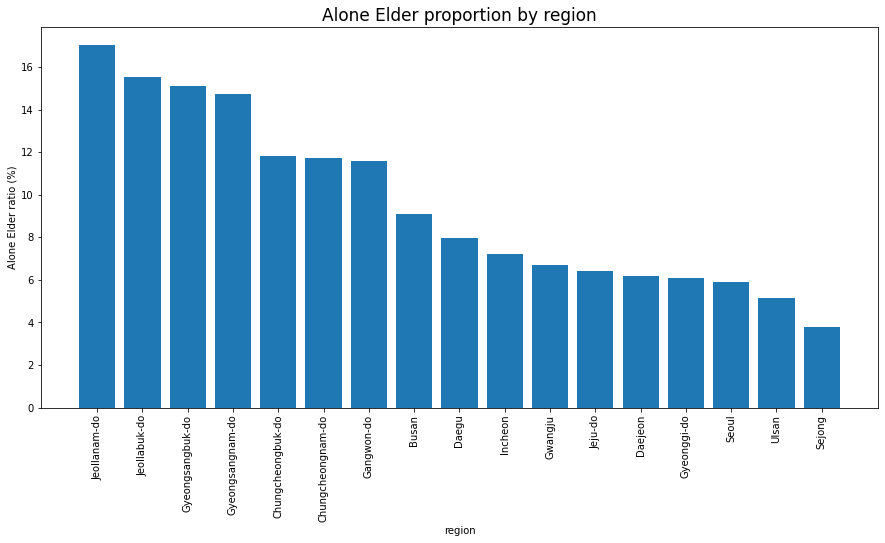

In [33]:
fig, ax = plt.subplots(figsize=(15, 7))
plt.title('Alone Elder proportion by region', fontsize=17)
plt.xticks(rotation=90)
plt.bar(region_alone.index, region_alone.alone_ratio)
plt.xlabel('region')
plt.ylabel('Alone Elder ratio (%)')
plt.show()

分析結果：獨居老人的區域差異就比教育情形來得顯著許多。為了作出合理的假設，可能需要先釐清獨居老人的數量與都市化程度的關係。外部資料來源一樣是[http://index.go.kr/potal/main/EachDtlPageDetail.do?idx_cd=1007]

**獨居老人與人口之關係**

In [34]:
pop = [1790, 1820, 2674, 3356, 1619, 2180, 1521, 3400, 2450, 2939, 1493, 653, 1518, 13031, 9705, 1154, 304]
dense = [145, 226, 141, 318, 219, 265, 90, 4416, 2773, 2764, 2980, 353, 2813, 1279, 16034, 1088, 653]
region_alone['pop'] = pop
region_alone['dense'] = dense
display(region_alone)

,alone_ratio,pop,dense
province,,,
Jeollanam-do,17.030435,1790,145
Jeollabuk-do,15.533333,1820,226
Gyeongsangbuk-do,15.133333,2674,141
Gyeongsangnam-do,14.721053,3356,318
Chungcheongbuk-do,11.825000,1619,219
Chungcheongnam-do,11.706250,2180,265
Gangwon-do,11.578947,1521,90
Busan,9.094118,3400,4416
Daegu,7.966667,2450,2773


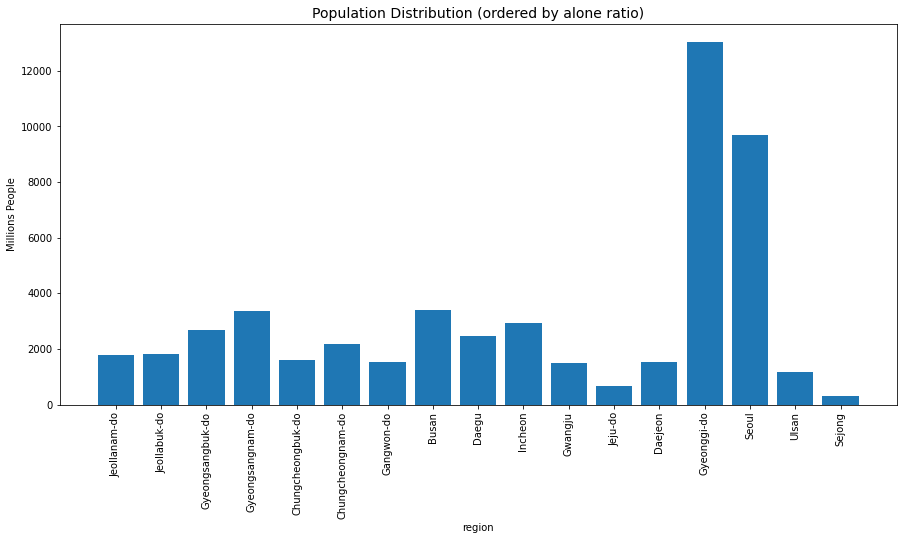

In [35]:
fig, ax = plt.subplots(figsize=(15, 7))
plt.title('Population Distribution (ordered by alone ratio)', fontsize=14)
plt.xticks(rotation=90)
plt.bar(region_alone.index, region_alone['pop'])
plt.xlabel('region')
plt.ylabel('Millions People')
plt.show()

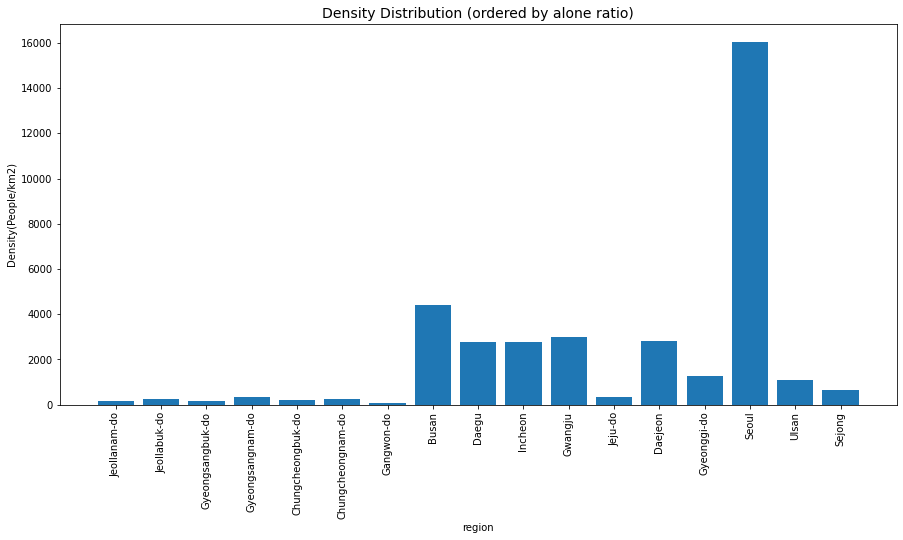

In [36]:
fig, ax = plt.subplots(figsize=(15, 7))
plt.title('Density Distribution (ordered by alone ratio)', fontsize=14)
plt.xticks(rotation=90)
plt.bar(region_alone.index, region_alone['dense'])
plt.xlabel('region')
plt.ylabel('Density(People/km2)')
plt.show()

分析結果：單從密度分布已可推斷大都市的獨居老人比例都是普遍偏低的，比較密集也意味著減少獨居的機會。利用這個特點假設確診數高的區域傾向為獨居老人多的區域。初步的猜想是獨居的老人不太會跟別人互動，進而降低傳染機會。

**與確診數之關係**

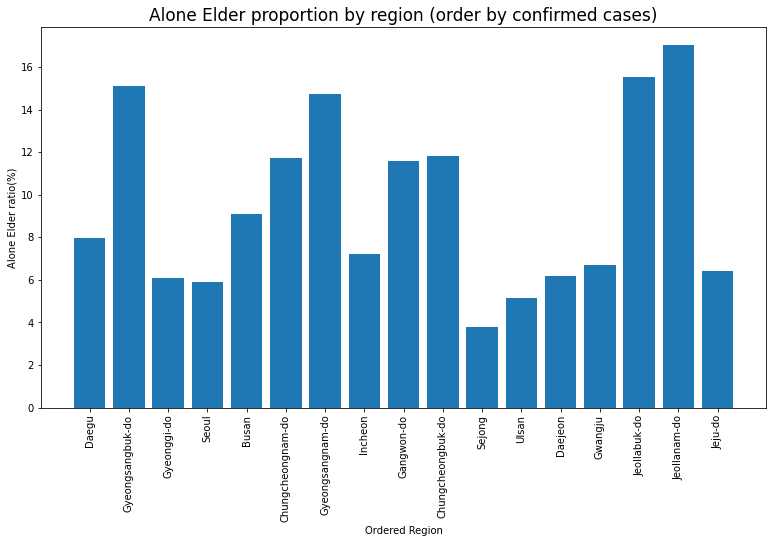

In [37]:
region_alone_order = pd.DataFrame()
for order in confirm_order:
    new_row = {'province':order, 'alone_ratio':region_alone.at[order,'alone_ratio']}
    region_alone_order  = region_alone_order.append(new_row,ignore_index=True)
region_alone_order  = region_alone_order [['province','alone_ratio']]


fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Alone Elder proportion by region (order by confirmed cases)', fontsize=17)
plt.xticks(rotation=90)
plt.xlabel('Ordered Region')
plt.ylabel('Alone Elder ratio(%)')
plt.bar(region_alone_order.province, region_alone_order.alone_ratio)
plt.show()

分析結果：似乎沒有展示出太大的相關性，顯示獨居老人的比率並不是什麼很有力的證據。

### 療養院數量層面

**各地療養院情形對比**

In [38]:
region_nurse = pd.DataFrame()
region_nurse['nurse_ratio'] = df_region[df_region.province!='Korea'].groupby('province').mean().nursing_home_count
region_nurse['nurse_ratio'] =region_nurse['nurse_ratio'] / region_nurse['nurse_ratio'].sum() * 100
region_nurse = region_nurse.sort_values(ascending=False, by = 'nurse_ratio')
region_nurse

,nurse_ratio
province,
Seoul,13.485947
Gyeonggi-do,9.874080
Jeju-do,9.598929
Daegu,8.708855
Daejeon,7.668864
Gwangju,7.329624
Incheon,6.303963
Busan,6.124448
Ulsan,4.628560


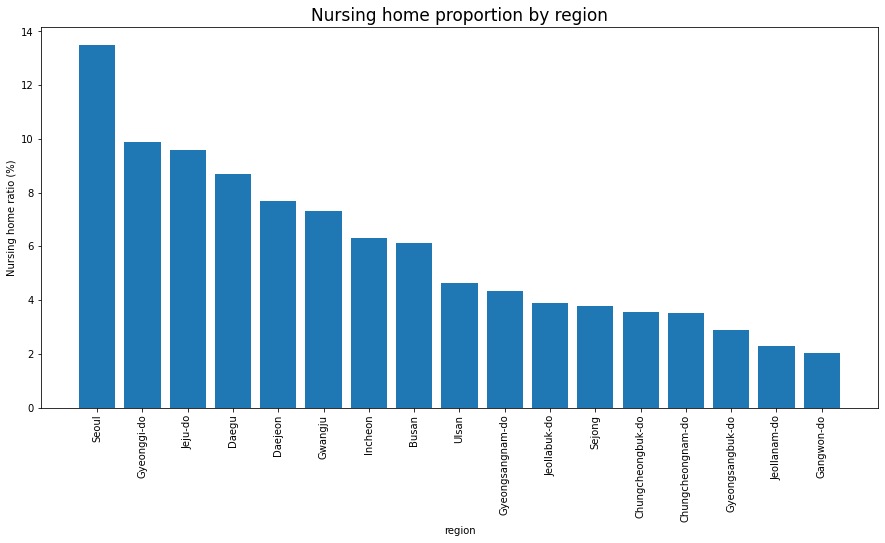

In [39]:
fig, ax = plt.subplots(figsize=(15, 7))
plt.title('Nursing home proportion by region', fontsize=17)
plt.xticks(rotation=90)
plt.bar(region_nurse.index, region_nurse.nurse_ratio)
plt.xlabel('region')
plt.ylabel('Nursing home ratio (%)')
plt.show()

分析結果：對這個的特徵著手的動機是對各地區的醫療水準與確診數的相對數量呈現怎麼樣的一個相關。而療養院的數量應該可以作為參考性的指標。

**與確診數之關係**

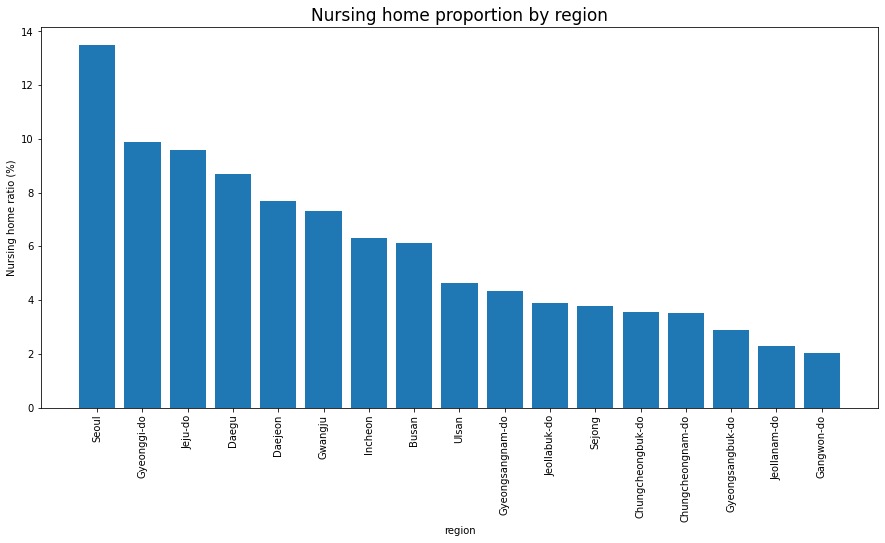

In [40]:
fig, ax = plt.subplots(figsize=(15, 7))
plt.title('Nursing home proportion by region', fontsize=17)
plt.xticks(rotation=90)
plt.bar(region_nurse.index, region_nurse.nurse_ratio)
plt.xlabel('region')
plt.ylabel('Nursing home ratio (%)')
plt.show()

分析結果：一樣是十分紛亂無法看出強的相關性。不過慶尚北道的療養院數偏低，確診數卻排在前面，或許是一個警訊。

### 1-3 地區性之足跡分析

**各地足跡之分布**

In [41]:
df_route = patientRoute
display(df_route.head(5).append(df_route.tail(5)))

,patient_id,global_num,date,province,city,type,latitude,longitude
0,1000000001,2.0,2020-01-22,Gyeonggi-do,Gimpo-si,airport,37.615246,126.715632
1,1000000001,2.0,2020-01-24,Seoul,Jung-gu,hospital,37.567241,127.005659
2,1000000002,5.0,2020-01-25,Seoul,Seongbuk-gu,etc,37.592560,127.017048
3,1000000002,5.0,2020-01-26,Seoul,Seongbuk-gu,store,37.591810,127.016822
4,1000000002,5.0,2020-01-26,Seoul,Seongdong-gu,public_transportation,37.563992,127.029534
7274,6100000090,NaN,2020-03-24,Seoul,Gangseo-gu,airport,37.558654,126.794474
7275,6100000090,NaN,2020-03-24,Busan,Gangseo-gu,airport,35.173220,128.946459
7276,6100000090,NaN,2020-03-25,Gyeongsangnam-do,Yangsan-si,store,35.336944,129.026389
7277,6100000090,NaN,2020-03-25,Gyeongsangnam-do,Yangsan-si,hospital,35.335757,129.025003
7278,6100000090,NaN,2020-03-25,Gyeongsangnam-do,Yangsan-si,store,35.336944,129.026389


In [42]:
route_region = pd.DataFrame()
route_count = df_route.groupby('province').count()
display(route_count)
route_region['region'] = route_count.index
route_region['records'] = route_count.patient_id.values
route_region = route_region.sort_values('records', ascending=False)
route_region

,patient_id,global_num,date,city,type,latitude,longitude
province,,,,,,,
Busan,728,5,728,728,728,728,728
Chungcheongbuk-do,149,8,149,149,149,149,149
Chungcheongnam-do,685,15,685,685,685,685,685
Daegu,266,87,266,266,266,266,266
Daejeon,46,6,46,46,46,46,46
Gangwon-do,324,24,324,324,324,324,324
Gwangju,122,110,122,122,122,122,122
Gyeonggi-do,262,179,262,262,262,262,262
Gyeongsangbuk-do,856,208,856,856,856,856,856


,region,records
14,Seoul,3029
8,Gyeongsangbuk-do,856
0,Busan,728
2,Chungcheongnam-do,685
10,Incheon,434
5,Gangwon-do,324
3,Daegu,266
7,Gyeonggi-do,262
9,Gyeongsangnam-do,239
1,Chungcheongbuk-do,149


由於地區的數量過多，而且某些區的記錄少到幾乎看不太出來，因此將記錄比較少(<=200)的區域合併成 `Others`

In [43]:
new_row = {'region':'Others', 'records':route_region.iloc[8:,1].sum()}
#append row to the dataframe
route_region = route_region.append(new_row, ignore_index=True).sort_values('records', ascending=False)[0:10]
route_region


,region,records
0,Seoul,3029
1,Gyeongsangbuk-do,856
2,Busan,728
16,Others,695
3,Chungcheongnam-do,685
4,Incheon,434
5,Gangwon-do,324
6,Daegu,266
7,Gyeonggi-do,262
8,Gyeongsangnam-do,239


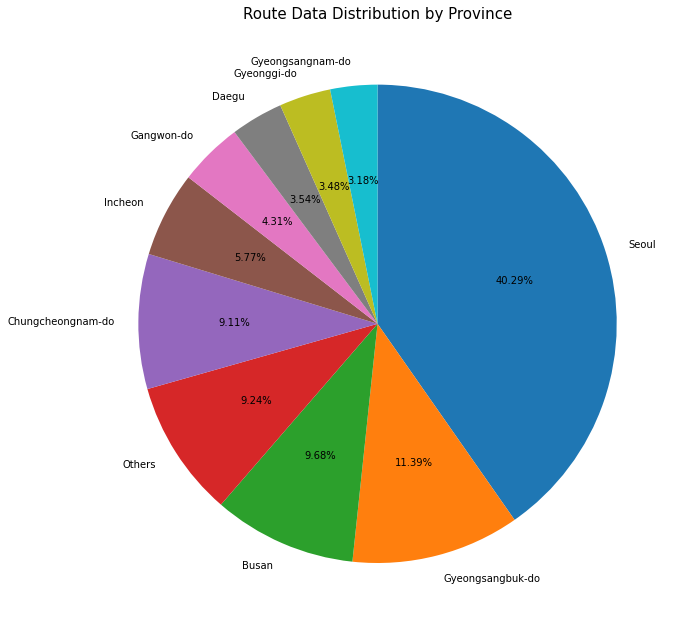

In [44]:
fig, ax = plt.subplots(figsize=(11, 11))
plt.title(f'Route Data Distribution by Province', fontsize=15)
plt.pie(route_region.records
        , labels=route_region.region
        , autopct='%.2f%%'
        , startangle=90
        , counterclock=False)
plt.show()

- 分析結果:
    從上面的圓餅圖我們可看到首爾擁有相對最大宗的記錄，然而和最嚴重的爆發區相比數量幾乎是其十倍。這說明了有歸檔的足跡數與確診數沒有太大的關聯
    ，只能說明首爾是最大的都市，追蹤的系統最完善因此擁有的記錄也最多。

**單一病人擁有記錄統計**

In [45]:
route_patient = pd.DataFrame()
patient_count = df_route.groupby('patient_id').count()
display(patient_count.head(10))
route_patient['patient'] = patient_count.index
route_patient['records'] = patient_count.type.values
route_patient = route_patient.sort_values('records', ascending=False)
route_patient.head(5).append(route_patient.tail(5))


,global_num,date,province,city,type,latitude,longitude
patient_id,,,,,,,
1000000001,2,2,2,2,2,2,2
1000000002,13,13,13,13,13,13,13
1000000003,2,2,2,2,2,2,2
1000000004,1,1,1,1,1,1,1
1000000005,1,1,1,1,1,1,1
1000000006,1,1,1,1,1,1,1
1000000007,1,1,1,1,1,1,1
1000000008,1,1,1,1,1,1,1
1000000009,10,10,10,10,10,10,10


,patient,records
376,1000000417,45
906,3009000014,42
799,1400000021,38
905,3009000013,37
1178,6016000012,36
55,1000000059,1
565,1000000635,1
813,1400000040,1
815,1400000042,1
835,1600000021,1


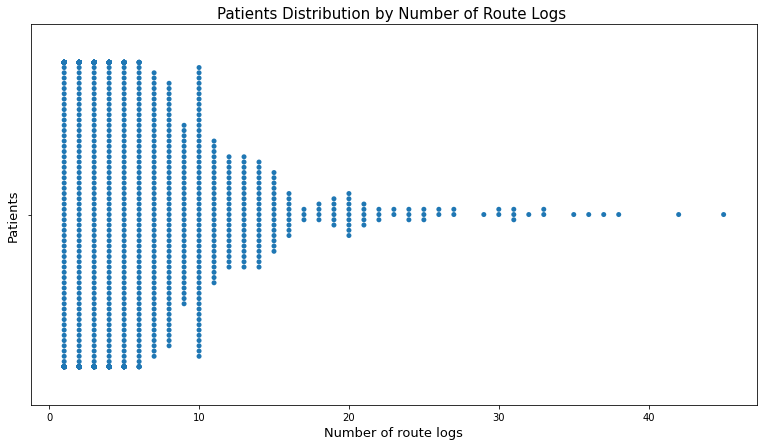

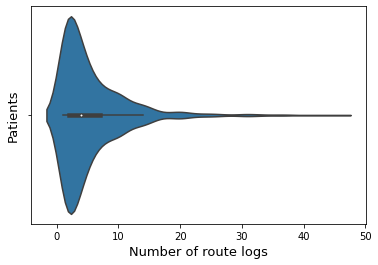

In [46]:
fig, ax = plt.subplots(figsize=(13, 7))
plt.title(f'Patients Distribution by Number of Route Logs ', fontsize=15)
ax.set_xlabel('Number of route logs', size=13)
ax.set_ylabel('Patients', size=13)
sns.swarmplot(route_patient.records.values)
plt.show()
ax = sns.violinplot(x=route_patient.records.values)
ax.set_xlabel('Number of route logs', size=13)
ax.set_ylabel('Patients', size=13)
plt.show()

分析結果：由上面兩張圖可看出一名病患擁有的行蹤履歷主要集中在1到10位左右，但還是有零星的記錄特別多的病患。以下將對這些outlier仔細檢查其特徵。

**擁有過多足跡病患之特徵分析**

In [47]:
stat = route_patient.records.describe()
print(stat)
outlier_num = int(stat['75%'] + 1.5 * (stat['75%'] - stat['25%']))
outlier_count = len(route_patient[route_patient.records > outlier_num])
print(f'outlier為超過{outlier_num}人以上，共有{outlier_count}人')

count    1319.000000
mean        5.518575
std         5.592192
min         1.000000
25%         2.000000
50%         4.000000
75%         7.000000
max        45.000000
Name: records, dtype: float64
outlier為超過14人以上，共有82人


In [48]:
patient_org = pd.read_csv(datasets[7])
print('擁有最多足跡的五名病患')
edge_ids = route_patient.head(5).patient.values
patient_most = pd.DataFrame()
for ids in edge_ids:
    temp = patient_org[patient_org.patient_id == ids]
    temp['records'] = route_patient[route_patient.patient == ids].records.values[0]
    patient_most = patient_most.append(temp)
    
display(patient_most.T)


擁有最多足跡的五名病患


,416,1908,968,1907,3169
patient_id,1000000417,3009000014,1400000021,3009000013,6016000012
global_num,9644,NaN,7628,NaN,NaN
sex,female,male,male,male,male
birth_year,1992,1969,1992,1954,2000
age,20s,50s,20s,60s,20s
country,Korea,Korea,Korea,Korea,Korea
province,Seoul,Gangwon-do,Incheon,Gangwon-do,Gyeongsangbuk-do
city,Mapo-gu,Wonju-si,Namdong-gu,Wonju-si,Yecheon-gun
disease,NaN,NaN,NaN,NaN,NaN
infection_case,overseas inflow,Shincheonji Church,Guro-gu Call Center,contact with patient,contact with patient


註：Outlier的算法為 Q3 + 1.5 * (Q3 − Q1)

分析結果:從上面的圓餅圖我們可看到足跡最廣的過半數都是年輕人，而且他們幾乎都出院了，或許這是因為免疫力比較強的人比較會到處趴趴走。並且顯示出男性遠超過女性的比例（有可能是男性比較喜歡出去外面，或比較誠實匯報自己的行蹤），另外病患的接觸數非空值的都不低，可以合理推斷那些沒有資料的也應該與不少病患接觸過。

**最常去的地點統計**

In [49]:
patient_type = pd.DataFrame()
type_count = df_route.groupby('type').count()
display(type_count)

patient_type['type'] = type_count.index
patient_type['records'] = type_count.date.values
patient_type = patient_type.sort_values('records', ascending=False)
patient_type.set_index('type' , inplace=True)
display(patient_type)


,patient_id,global_num,date,province,city,latitude,longitude
type,,,,,,,
academy,15,6,15,15,15,15,15
administrative_area_level_1,14,0,14,14,14,14,14
airport,262,204,262,262,262,262,262
bakery,27,13,27,27,27,27,27
bank,33,17,33,33,33,33,33
bar,26,23,26,26,26,26,26
beauty_salon,21,9,21,21,21,21,21
cafe,123,75,123,123,123,123,123
church,152,93,152,152,152,152,152


,records
type,
etc,2152
hospital,2106
store,687
restaurant,576
public_transportation,550
airport,262
pharmacy,240
church,152
cafe,123


由於類別過多，以下將整併為食衣住行育樂，再加上以些特別的場所以利圖形的繪製。

In [50]:
route_type = pd.DataFrame()
directs = ['hospital','etc','store','pharmacy','church']
for direct in directs:
    new_row = {'type':direct, 'records':patient_type.at[direct,'records']}
    route_type = route_type.append(new_row,ignore_index=True)
route_type

,records,type
0,2106.0,hospital
1,2152.0,etc
2,687.0,store
3,240.0,pharmacy
4,152.0,church


將 `restaurant`、`cafe`、 `pc_cafe`、`bakery` 合併為 `食(Eat)`

In [51]:
eat_types = ['restaurant','cafe','pc_cafe','bakery']
eat_sum = 0
for eat_type in eat_types:
    eat_sum = eat_sum + patient_type.at[eat_type,'records']
new_row = {'type':'Eat', 'records':eat_sum}
route_type = route_type.append(new_row,ignore_index=True)
route_type

,records,type
0,2106.0,hospital
1,2152.0,etc
2,687.0,store
3,240.0,pharmacy
4,152.0,church
5,810.0,Eat


將 `lodging`、`real_estate_agency` 合併為 `住(Lodge)`

In [52]:
eat_types = ['lodging','real_estate_agency']
eat_sum = 0
for eat_type in eat_types:
    eat_sum = eat_sum + patient_type.at[eat_type,'records']
new_row = {'type':'Lodge', 'records':eat_sum}
route_type = route_type.append(new_row,ignore_index=True)
route_type

,records,type
0,2106.0,hospital
1,2152.0,etc
2,687.0,store
3,240.0,pharmacy
4,152.0,church
5,810.0,Eat
6,64.0,Lodge


將 `public_transportation`、`airport`、 `gas_station`合併為 `行(Traffic)`

In [53]:
eat_types = ['public_transportation','airport','gas_station']
eat_sum = 0
for eat_type in eat_types:
    eat_sum = eat_sum + patient_type.at[eat_type,'records']
new_row = {'type':'Traffic', 'records':eat_sum}
route_type = route_type.append(new_row,ignore_index=True)
route_type

,records,type
0,2106.0,hospital
1,2152.0,etc
2,687.0,store
3,240.0,pharmacy
4,152.0,church
5,810.0,Eat
6,64.0,Lodge
7,824.0,Traffic


將 `school`、`academy`、 `university`合併為 `育(School)`

In [54]:
eat_types = ['school','academy','university']
eat_sum = 0
for eat_type in eat_types:
    eat_sum = eat_sum + patient_type.at[eat_type,'records']
new_row = {'type':'School', 'records':eat_sum}
route_type = route_type.append(new_row,ignore_index=True)
route_type

,records,type
0,2106.0,hospital
1,2152.0,etc
2,687.0,store
3,240.0,pharmacy
4,152.0,church
5,810.0,Eat
6,64.0,Lodge
7,824.0,Traffic
8,87.0,School


將 `gym`、`beauty_salon`、 `karaoke`、`park` 合併為 `樂(Fun)`

In [55]:
eat_types = ['gym','beauty_salon','karaoke','park']
eat_sum = 0
for eat_type in eat_types:
    eat_sum = eat_sum + patient_type.at[eat_type,'records']
new_row = {'type':'Fun', 'records':eat_sum}
route_type = route_type.append(new_row,ignore_index=True)
route_type

,records,type
0,2106.0,hospital
1,2152.0,etc
2,687.0,store
3,240.0,pharmacy
4,152.0,church
5,810.0,Eat
6,64.0,Lodge
7,824.0,Traffic
8,87.0,School
9,66.0,Fun


將 `bank`、`post_office`、 `administrative_area_level_1` 合併為 `工作(Office)`

In [56]:
eat_types = ['bank','post_office','administrative_area_level_1']
eat_sum = 0
for eat_type in eat_types:
    eat_sum = eat_sum + patient_type.at[eat_type,'records']
new_row = {'type':'Office', 'records':eat_sum}
route_type = route_type.append(new_row,ignore_index=True)
route_type

,records,type
0,2106.0,hospital
1,2152.0,etc
2,687.0,store
3,240.0,pharmacy
4,152.0,church
5,810.0,Eat
6,64.0,Lodge
7,824.0,Traffic
8,87.0,School
9,66.0,Fun


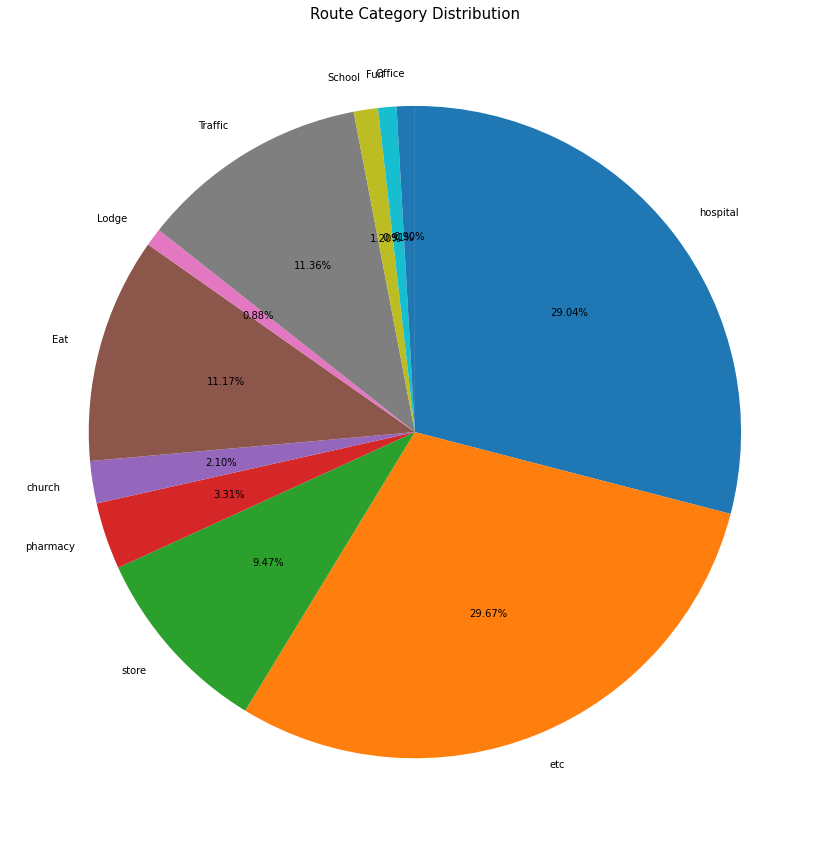

In [57]:
fig, ax = plt.subplots(figsize=(15, 15))
plt.title(f'Route Category Distribution', fontsize=15)
plt.pie(route_type.records
        , labels=route_type.type
        , autopct='%.2f%%'
        , startangle=90
        , counterclock=False)
plt.show()

分析結果：從上圖可得知去醫院的記錄比重還是最大的（畢竟被送到醫院去一定有記錄），再來是生活必須的「食」、「行」部分。造成疫情大爆發的教堂沒有想像中的多，也沒看出有很多人去藥局領藥的這個傾向。育樂的比例也很低，和學校、公司等差不多。不過需要注意的是無法歸類的也佔很大的一部分，很可能需要分配一些給育樂類以及工作類，畢竟這兩個類別最有隱匿的可能性。

**足跡變動量趨勢分析**

本小節的目的在於探討每日病患記錄總量的變動趨勢與新增確診數之關係。記錄越多，很有可能人民和政府的憂患意識也越大，能達到抑制確診數的效果也說不定。首先將資料以每日統計並標準化。

In [58]:
df_daily_log = df_route.groupby('date').count()[:-13]
df_daily_log['total'] = df_daily_log['patient_id']
df_daily_log = df_daily_log[['total']]
df_daily_log = df_daily_log.reset_index()
display(df_daily_log.head(5).append(df_daily_log.tail(5)))

df_daily_log['total'].unique()

,date,total
0,2020-01-20,1
1,2020-01-21,1
2,2020-01-22,2
3,2020-01-23,2
4,2020-01-24,5
97,2020-04-26,12
98,2020-04-27,4
99,2020-04-28,4
100,2020-04-29,1
101,2020-04-30,6


array([  1,   2,   5,  14,  10,   9,   7,   4,  16,   6,   8,  13,  11,
        18,  23,  26, 109, 134, 170, 236, 267, 319, 254, 197, 328, 216,
       241, 226, 199, 165, 106, 154, 126, 115, 123, 172, 140, 114, 161,
       122,  77,  60,  54,  56,  59,  74,  85,  83,  72,  62,  33,  57,
        89,  90,  88,  44,  70,  42,  76,  65,  71,  40,  28,  24,  22,
        17,  15,  12], dtype=int64)

In [59]:
#計算每日新增確診數
for index, row in df_daily_log.iterrows():
    
    if index == 0:
        df_daily_log.at[index,'new_logged'] = 1
    else:
        df_daily_log.at[index,'new_logged'] = df_daily_log.at[index,'total'] - df_daily_log.at[index - 1,'total']
display(df_daily_log.head(5).append(df_daily_log.tail(5)))

,date,total,new_logged
0,2020-01-20,1,1.0
1,2020-01-21,1,0.0
2,2020-01-22,2,1.0
3,2020-01-23,2,0.0
4,2020-01-24,5,3.0
97,2020-04-26,12,6.0
98,2020-04-27,4,-8.0
99,2020-04-28,4,0.0
100,2020-04-29,1,-3.0
101,2020-04-30,6,5.0


In [60]:
#正規化每日新增確診數
df_daily_log_describe = df_daily_log['new_logged'].describe()
display(df_daily_log_describe)
mean = (df_daily_log_describe.loc['mean'])
std = (df_daily_log_describe.loc['std'])
df_daily_log['std_new_logged'] = df_daily_log['new_logged'].apply(lambda x : (x - mean) / std)
display(df_daily_log.head(5).append(df_daily_log.tail(5)))

count    102.000000
mean       0.058824
std       29.288535
min     -112.000000
25%       -9.500000
50%        0.000000
75%        5.750000
max      131.000000
Name: new_logged, dtype: float64

,date,total,new_logged,std_new_logged
0,2020-01-20,1,1.0,0.032135
1,2020-01-21,1,0.0,-0.002008
2,2020-01-22,2,1.0,0.032135
3,2020-01-23,2,0.0,-0.002008
4,2020-01-24,5,3.0,0.100421
97,2020-04-26,12,6.0,0.202850
98,2020-04-27,4,-8.0,-0.275153
99,2020-04-28,4,0.0,-0.002008
100,2020-04-29,1,-3.0,-0.104438
101,2020-04-30,6,5.0,0.168707


In [61]:
df_time = pd.read_csv(datasets[4])
df_float_time = df_time[:-14]
display(df_float_time.head(5).append(df_float_time.tail(5)))

,date,time,test,negative,confirmed,released,deceased
0,2020-01-20,16,1,0,1,0,0
1,2020-01-21,16,1,0,1,0,0
2,2020-01-22,16,4,3,1,0,0
3,2020-01-23,16,22,21,1,0,0
4,2020-01-24,16,27,25,2,0,0
97,2020-04-26,0,598285,578558,10728,8717,242
98,2020-04-27,0,601660,582027,10738,8764,243
99,2020-04-28,0,608514,588559,10752,8854,244
100,2020-04-29,0,614197,595129,10761,8922,246
101,2020-04-30,0,619881,600482,10765,9059,247


In [62]:
#計算每日新增確診數
for index, row in df_float_time.iterrows():
    
    if index == 0:
        df_float_time.at[index,'new_confirmed'] = 1
    else:
        df_float_time.at[index,'new_confirmed'] = df_float_time.at[index,'confirmed'] - df_float_time.at[index - 1,'confirmed']
display(df_float_time.head(5).append(df_float_time.tail(5)))

,date,time,test,negative,confirmed,released,deceased,new_confirmed
0,2020-01-20,16,1,0,1,0,0,1.0
1,2020-01-21,16,1,0,1,0,0,0.0
2,2020-01-22,16,4,3,1,0,0,0.0
3,2020-01-23,16,22,21,1,0,0,0.0
4,2020-01-24,16,27,25,2,0,0,1.0
97,2020-04-26,0,598285,578558,10728,8717,242,10.0
98,2020-04-27,0,601660,582027,10738,8764,243,10.0
99,2020-04-28,0,608514,588559,10752,8854,244,14.0
100,2020-04-29,0,614197,595129,10761,8922,246,9.0
101,2020-04-30,0,619881,600482,10765,9059,247,4.0


In [63]:
#正規化每日新增確診數
new_confirmed_describe = df_float_time['new_confirmed'].describe()
display(new_confirmed_describe)
mean = (new_confirmed_describe.loc['mean'])
std = (new_confirmed_describe.loc['std'])
df_float_time['std_new_confirmed'] = df_float_time['new_confirmed'].apply(lambda x : (x - mean) / std)
display(df_float_time.head(5).append(df_float_time.tail(5)))

count    102.000000
mean     105.539216
std      166.330023
min        0.000000
25%        2.250000
50%       31.000000
75%      109.250000
max      813.000000
Name: new_confirmed, dtype: float64

,date,time,test,negative,confirmed,released,deceased,new_confirmed,std_new_confirmed
0,2020-01-20,16,1,0,1,0,0,1.0,-0.628505
1,2020-01-21,16,1,0,1,0,0,0.0,-0.634517
2,2020-01-22,16,4,3,1,0,0,0.0,-0.634517
3,2020-01-23,16,22,21,1,0,0,0.0,-0.634517
4,2020-01-24,16,27,25,2,0,0,1.0,-0.628505
97,2020-04-26,0,598285,578558,10728,8717,242,10.0,-0.574395
98,2020-04-27,0,601660,582027,10738,8764,243,10.0,-0.574395
99,2020-04-28,0,608514,588559,10752,8854,244,14.0,-0.550347
100,2020-04-29,0,614197,595129,10761,8922,246,9.0,-0.580408
101,2020-04-30,0,619881,600482,10765,9059,247,4.0,-0.610468


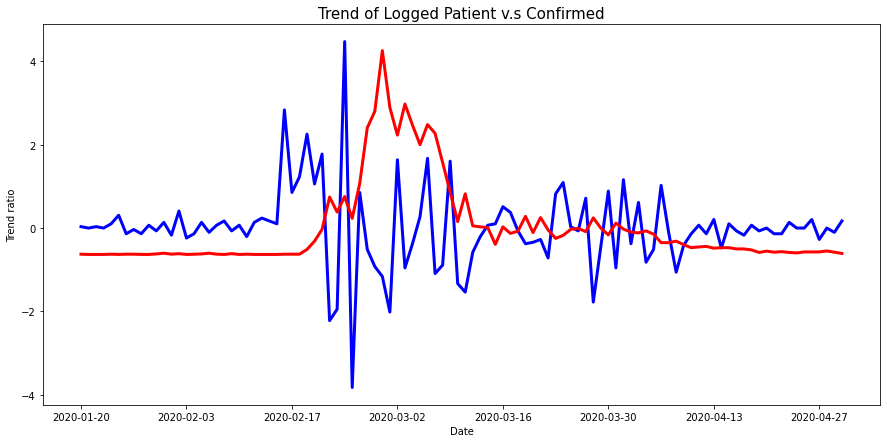

In [64]:
fig, ax = plt.subplots(figsize=(15, 7))
plt.title('Trend of Logged Patient v.s Confirmed', size=15)
plt.plot(df_daily_log['date'], df_daily_log['std_new_logged']
         , color='blue'
         , lw=3)

plt.plot(df_float_time['date'], df_float_time['std_new_confirmed']
         , color='red'
         , lw=3)

ax.set_xticks(ax.get_xticks()[::14])
plt.xlabel('Date')
plt.ylabel('Trend ratio')
plt.show()

分析結果：2月20幾號那個極端的波峰是個很好的預兆，果然幾天後確診數就來到了高點。隨著確診數趨於平淡，記錄的變化值是產生了震盪才趨於平緩，說明人們警戒的狀況需要一段時間才能平復。值得一提的是好幾次足跡的記錄來到局部最低值時，後面確診數常常都有上升的趨勢，這提醒了我們不能輕易對疫情鬆懈。

**最早記錄日期與確認日期差距分析**

這個小節並不作視覺化而是單純的統計，主要是探討一個病人被診出後平均可追溯的記錄是幾天。並試著分析某些特別的個案其共同擁有的特性。

In [65]:
df_route_diff = df_route.groupby('patient_id').min().reset_index()
display(df_route_diff)

,patient_id,global_num,date,province,city,type,latitude,longitude
0,1000000001,2.0,2020-01-22,Gyeonggi-do,Gimpo-si,airport,37.567241,126.715632
1,1000000002,5.0,2020-01-25,Seoul,Dongdaemun-gu,etc,37.523674,127.009766
2,1000000003,6.0,2020-01-26,Seoul,Jongno-gu,church,37.572950,126.979358
3,1000000004,7.0,2020-01-30,Seoul,Jungnang-gu,hospital,37.612772,127.098167
4,1000000005,9.0,2020-01-31,Seoul,Jungnang-gu,hospital,37.612772,127.098167
...,...,...,...,...,...,...,...,...
1314,6100000086,NaN,2020-03-14,Daegu,Changwon-si,bank,35.219921,128.466686
1315,6100000087,NaN,2020-03-15,Gyeongsangnam-do,Changwon-si,etc,35.226772,128.639094
1316,6100000088,NaN,2020-03-05,Gyeongsangnam-do,Changwon-si,bakery,35.222376,128.642847
1317,6100000089,NaN,2020-03-21,Gyeongsangnam-do,Haman-gun,etc,35.275725,128.410312


In [66]:
df_pat = pd.read_csv(datasets[7])
df_pat = df_pat[['patient_id','confirmed_date']]
display(df_pat.head(5).append(df_pat.tail(5)))

,patient_id,confirmed_date
0,1000000001,2020-01-23
1,1000000002,2020-01-30
2,1000000003,2020-01-30
3,1000000004,2020-01-30
4,1000000005,2020-01-31
3514,7000000010,2020-04-03
3515,7000000011,2020-04-03
3516,7000000012,2020-04-03
3517,7000000013,2020-04-14
3518,7000000014,2020-05-09


In [67]:
df_merge_diff = pd.merge(df_route_diff,df_pat, on='patient_id')
display(df_merge_diff)

,patient_id,global_num,date,province,city,type,latitude,longitude,confirmed_date
0,1000000001,2.0,2020-01-22,Gyeonggi-do,Gimpo-si,airport,37.567241,126.715632,2020-01-23
1,1000000002,5.0,2020-01-25,Seoul,Dongdaemun-gu,etc,37.523674,127.009766,2020-01-30
2,1000000003,6.0,2020-01-26,Seoul,Jongno-gu,church,37.572950,126.979358,2020-01-30
3,1000000004,7.0,2020-01-30,Seoul,Jungnang-gu,hospital,37.612772,127.098167,2020-01-30
4,1000000005,9.0,2020-01-31,Seoul,Jungnang-gu,hospital,37.612772,127.098167,2020-01-31
...,...,...,...,...,...,...,...,...,...
1314,6100000086,NaN,2020-03-14,Daegu,Changwon-si,bank,35.219921,128.466686,2020-03-19
1315,6100000087,NaN,2020-03-15,Gyeongsangnam-do,Changwon-si,etc,35.226772,128.639094,2020-03-21
1316,6100000088,NaN,2020-03-05,Gyeongsangnam-do,Changwon-si,bakery,35.222376,128.642847,2020-03-22
1317,6100000089,NaN,2020-03-21,Gyeongsangnam-do,Haman-gun,etc,35.275725,128.410312,2020-03-23


In [68]:
#Redundancy Check
df_merge_diff['confirmed_date'].describe()

count           1319
unique            94
top       2020-02-28
freq              56
Name: confirmed_date, dtype: object

In [69]:
df_merge_diff['TimeDiff'] = pd.to_datetime(df_merge_diff['confirmed_date']) - pd.to_datetime(df_merge_diff['date'])
df_merge_diff['TimeDiff'] = df_merge_diff['TimeDiff'].apply(lambda x : x.days)
df_merge_diff

,patient_id,global_num,date,province,city,type,latitude,longitude,confirmed_date,TimeDiff
0,1000000001,2.0,2020-01-22,Gyeonggi-do,Gimpo-si,airport,37.567241,126.715632,2020-01-23,1
1,1000000002,5.0,2020-01-25,Seoul,Dongdaemun-gu,etc,37.523674,127.009766,2020-01-30,5
2,1000000003,6.0,2020-01-26,Seoul,Jongno-gu,church,37.572950,126.979358,2020-01-30,4
3,1000000004,7.0,2020-01-30,Seoul,Jungnang-gu,hospital,37.612772,127.098167,2020-01-30,0
4,1000000005,9.0,2020-01-31,Seoul,Jungnang-gu,hospital,37.612772,127.098167,2020-01-31,0
...,...,...,...,...,...,...,...,...,...,...
1314,6100000086,NaN,2020-03-14,Daegu,Changwon-si,bank,35.219921,128.466686,2020-03-19,5
1315,6100000087,NaN,2020-03-15,Gyeongsangnam-do,Changwon-si,etc,35.226772,128.639094,2020-03-21,6
1316,6100000088,NaN,2020-03-05,Gyeongsangnam-do,Changwon-si,bakery,35.222376,128.642847,2020-03-22,17
1317,6100000089,NaN,2020-03-21,Gyeongsangnam-do,Haman-gun,etc,35.275725,128.410312,2020-03-23,2


In [70]:
#Redundancy Check
stat = df_merge_diff['TimeDiff'].describe()
display(stat)
lower_bound = int(stat['25%'] - 1.5 * (stat['75%'] - stat['25%']))
upper_bound = int(stat['75%'] + 1.5 * (stat['75%'] - stat['25%']))
lower_count = len(df_merge_diff[df_merge_diff.TimeDiff < lower_bound])
upper_count = len(df_merge_diff[df_merge_diff.TimeDiff > upper_bound])
outlier_count = lower_count + upper_count
print(f'outlier為超過{upper_bound}天以上及低於{lower_bound}天以下，共有{outlier_count}人')

count    1319.000000
mean        4.921911
std         5.137484
min        -7.000000
25%         2.000000
50%         4.000000
75%         7.000000
max        51.000000
Name: TimeDiff, dtype: float64

outlier為超過14天以上及低於-5天以下，共有59人


分析結果：從統計的報表我們在韓國平均可以對一個已經確診的病患追蹤到4天前的記錄。但極值則有點詭異。最多51天前就有資料以及確診了7天後才有記錄的患者，都值得我們注意。以下將進行進一步的分析。

**非常早就有記錄的病患分析**

In [71]:
display(df_merge_diff[df_merge_diff.TimeDiff >= 14].tail(5))

,patient_id,global_num,date,province,city,type,latitude,longitude,confirmed_date,TimeDiff
1250,6023000047,NaN,2020-02-24,Daegu,Jung-gu,etc,35.871435,128.601445,2020-03-09,14
1297,6100000065,NaN,2020-02-18,Daegu,Dalseong-gun,etc,34.871963,128.465523,2020-03-03,14
1300,6100000068,NaN,2020-02-18,Gyeongsangnam-do,Hapcheon-gun,etc,35.568029,128.163666,2020-03-04,15
1311,6100000083,NaN,2020-02-22,Daegu,Buk-gu,etc,34.856049,128.588890,2020-03-10,17
1316,6100000088,NaN,2020-03-05,Gyeongsangnam-do,Changwon-si,bakery,35.222376,128.642847,2020-03-22,17


分析結果：這些是確診前非常早就有記錄的人，推測是與當時疫情爆發時的病人有在同一個場所或接觸，受到監控後在兩週後被檢驗出陽性反應。而地點正好是佔確診80%的大邱及慶尚南道，顯然是和新天地事件有所關聯。至於行蹤的etc究竟是什麼耐人尋味。甚至有超過了二週的潛伏期才被發現的患者存在。

**非常晚才有記錄的病患分析**

In [72]:
display(df_merge_diff[df_merge_diff.TimeDiff < 0].tail(5))

,patient_id,global_num,date,province,city,type,latitude,longitude,confirmed_date,TimeDiff
1202,6020100054,54.0,2020-02-23,Gyeongsangbuk-do,Cheongdo-gun,hospital,35.648617,128.736829,2020-02-19,-4
1203,6020100055,55.0,2020-02-23,Gyeongsangbuk-do,Cheongdo-gun,hospital,35.648617,128.736829,2020-02-19,-4
1204,6020100107,107.0,2020-02-24,Gyeongsangbuk-do,Cheongdo-gun,hospital,35.648617,128.736829,2020-02-21,-3
1205,6020100286,286.0,2020-02-23,Gyeongsangbuk-do,Cheongdo-gun,hospital,35.648617,128.736829,2020-02-22,-1
1206,6020100298,298.0,2020-02-25,Gyeongsangbuk-do,Cheongdo-gun,hospital,35.648617,128.736829,2020-02-22,-3


分析結果：這些都是確診後過了幾天才開始有足跡記錄的。類別都是醫院，說明他們可能都已經在隔離中了。而地區正好都是在慶尚北路的清道郡，或許我們應該懷疑那個地方的管理出了什麼樣的問題。而這裡的確出現了國內首起的死亡案例，以及和大邱被設為特別照護區。

# PartII 病患特徵層面分析
-----------------------------------
   ## 使用的資料集：
   
   
  ### TimeAge
  資料集說明：
 本資料集是針對不同年齡層病患個別所作的記錄

 - date : 該筆記錄的日期
 - hour ： 該筆記錄的時間(hour), 採24小時制
 - age :  該群病患所屬的年齡層(20s代表20歲到29歲)
 - confirmed : 截止該筆資料的時間為止，該年齡層的人所累積的確診人數
 - deceased : 截止該筆資料的時間為止，該年齡層的人所累積的死亡人數
 

 ### TimeGender
  資料集說明：
 本資料集是針對性別病患個別所作的記錄

 - date : 該筆記錄的日期
 - hour ： 該筆記錄的時間(hour), 採24小時制
 - sex :  該群病患所屬的性別
 - confirmed : 截止該筆資料的時間為止，該性別的人所累積的確診人數
 - deceased : 截止該筆資料的時間為止，該性別的人所累積的死亡人數
   
   
   
 ### FloatingSoeul
  
資料集說明：
 本資料集是針對首爾市的浮動人口變化所作的記錄
 - date : 該筆記錄的日期
 - hour ： 該筆記錄的時間(hour), 採24小時制
 - province : 州（全部都是首爾）
 - city : 首爾下的各個子區域
 - birth_year : 該群浮動人口所屬的年齡層(20s代表20歲到29歲)
 - sex ： 該群浮動人口的性別
 - fp_num ： 該群浮動人口的人數
 
 
 
 
  ## 主要分析法：
 - 觀察性別、年齡等資訊，從分布、累積趨勢及每日趨勢三個面向著手
 - 觀察整體數據並修正異常值
 - 觀察浮動人口的組成份子(性別、年齡層)
 - 找出各子區域浮動人口的差異，並研判與當地確診數有何關聯
 - 研究浮動人口變動趨勢的成因與規律
 - 變動量分析，討論首爾的浮動人口變化對於確診數變化是否有指標性意義

### 2-1 性別層面之分析 

### 性別間確診率之比較(統計至2020-05-14)

**分布比例**

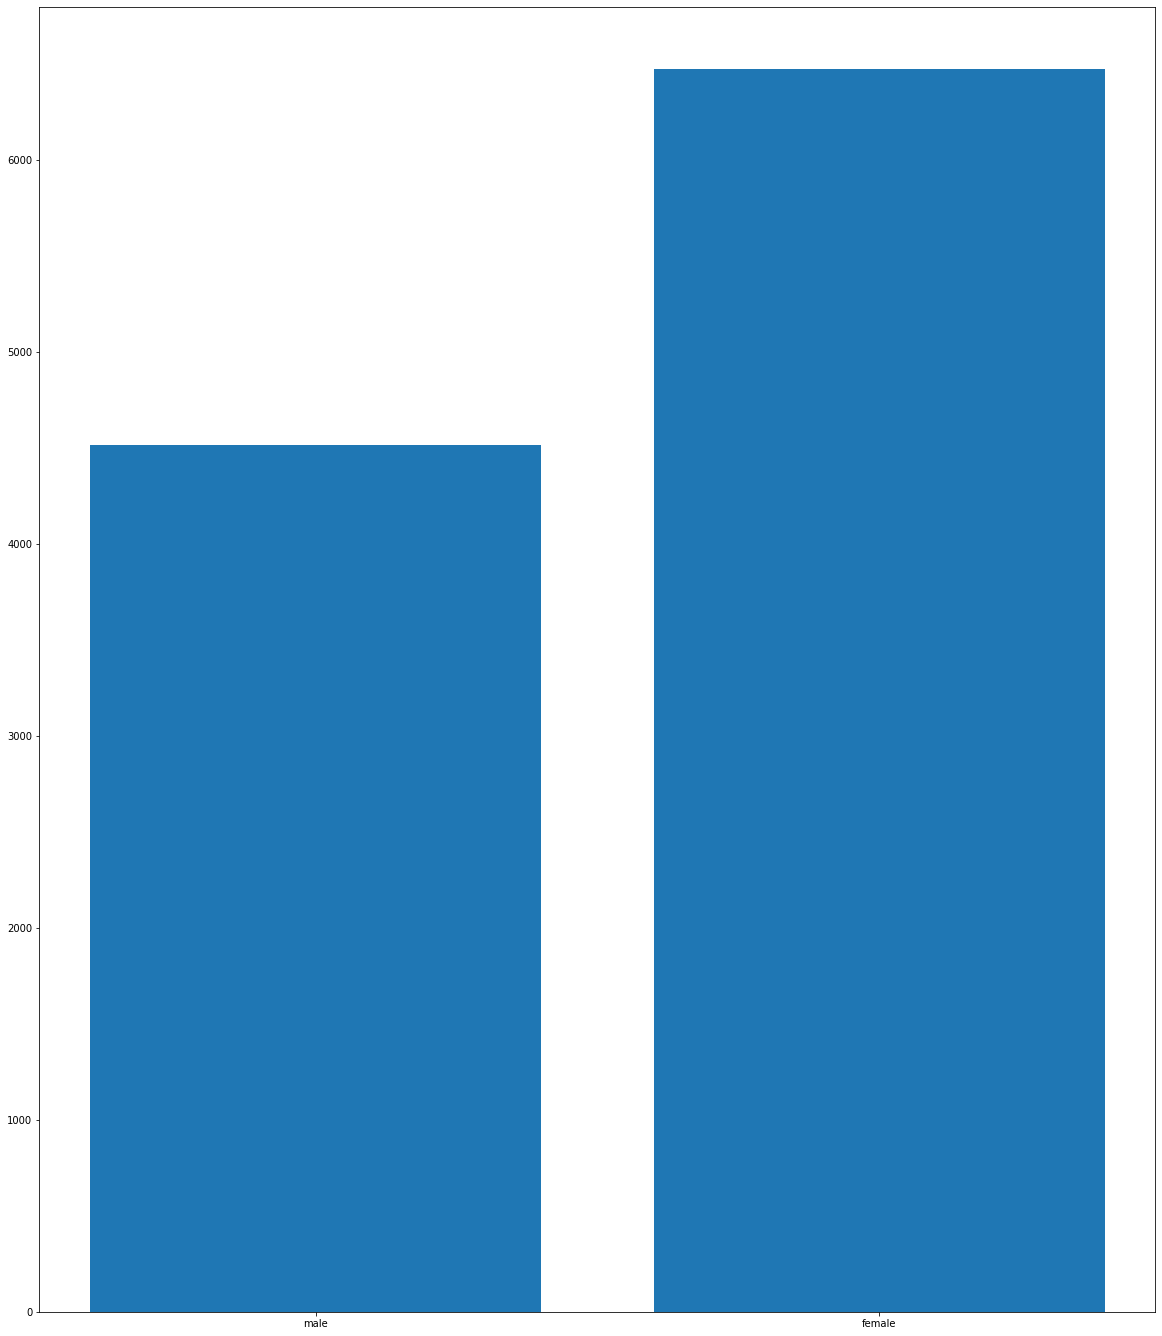

In [73]:
fig, ax = plt.subplots(figsize=(20,24))
sex_bar = ax.bar(gender['sex'], gender['confirmed'])

(-1.1108328494587658,
 1.100515849974227,
 -1.1131282540232492,
 1.122648825558023)

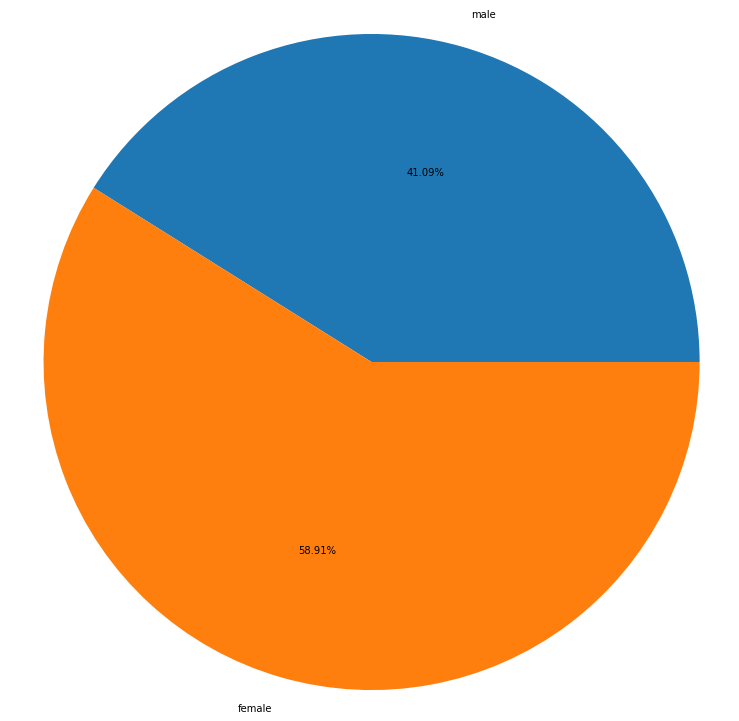

In [74]:
# pie plot
fig, ax = plt.subplots(figsize=(13,13))
order = pd.DataFrame()
order['age'] = gender['sex'].unique()
size = list(gender.loc[gender['date'] == '2020-05-14', 'confirmed'])
order['size'] = size
order = order.sort_values(by=['size'])

ax.pie(order['size'], labels=order['age'], autopct='%.2f%%')
plt.axis('equal')

分析結果：女性確診人數較男性高，可能與該地區性別比率影響。(http://www.koreaherald.com/view.php?ud=20191119000682)

**累積變動趨勢**

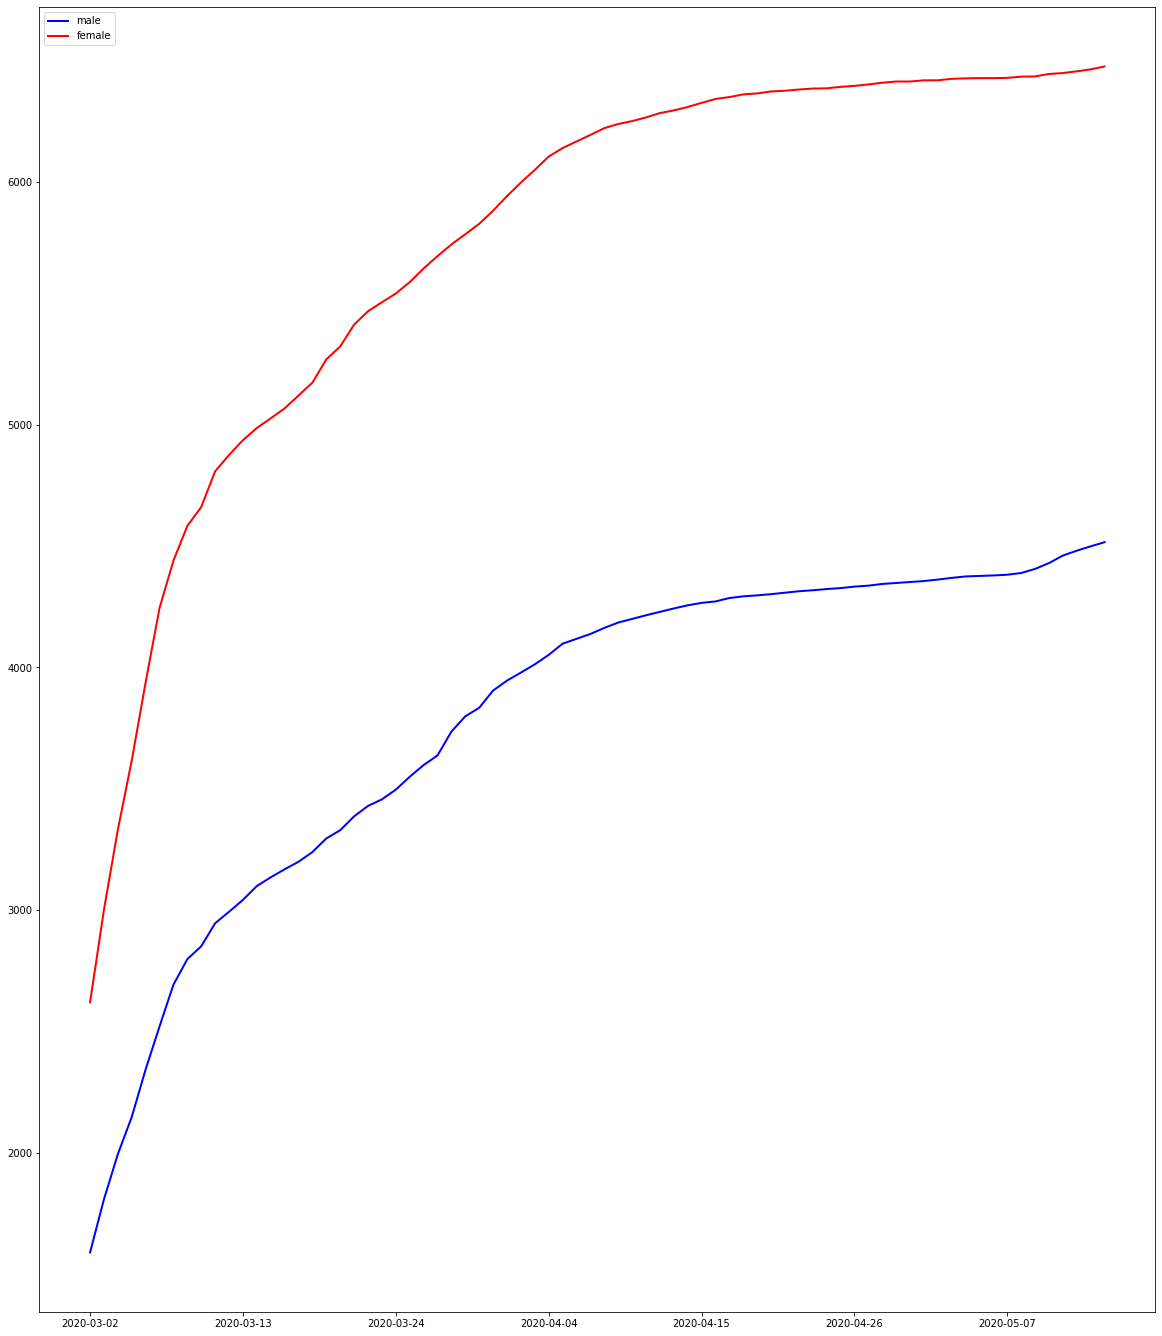

In [75]:
fig, ax = plt.subplots(figsize=(20,24))

# 連續圖
ax.plot(gender.date.unique(), gender.loc[gender['sex'] == 'male', 'confirmed'], color = 'blue', linewidth = 2, label='male')
ax.plot(gender.date.unique(), gender.loc[gender['sex'] == 'female', 'confirmed'], color = 'red', linewidth = 2, label='female')
plt.legend(loc='upper left')
ax.set_xticks(ax.get_xticks()[::11])

分析結果：女病患始終比男病患還多，而從末端的趨勢變化看到疫情穩定後確診數的增加主要來自於男性的貢獻。整體來說女性可能人多所以上升的比較急促，但變化比較平穩。

**每日變動趨勢**

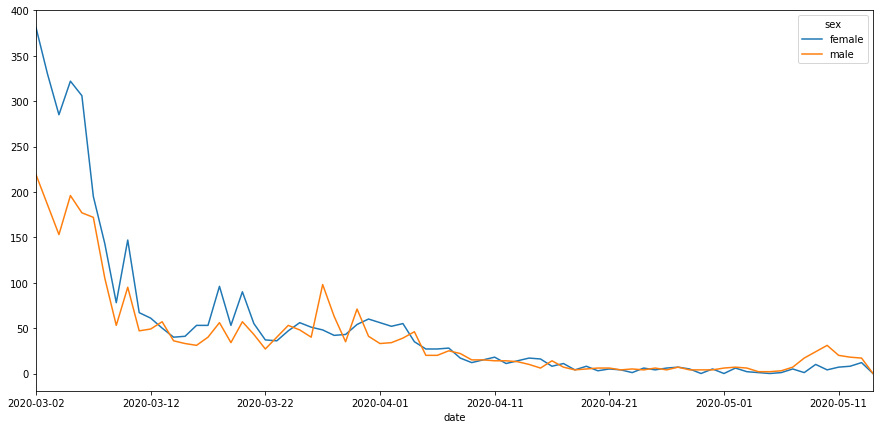

In [76]:

# daily confirmed
for title in gender['sex'].unique():
    day = gender.loc[gender['sex']==title, 'confirmed']
    gender.loc[gender['sex']==title, 'daily_confirmed'] = day.shift(-1) - day

gender.groupby(['date','sex'])['daily_confirmed'].sum() .unstack('sex', fill_value=0).plot(legend=True, figsize=(15,7))

分析結果：女性確診率較高，是因為爆發時女性確診數較多。每日病例可以觀察到並非女性較易確診。

### 性別間死亡率之比較(統計至2020-05-14)

**分布比例**

(-1.109608027519042,
 1.1004575251199544,
 -1.1074096077844104,
 1.1145510328176322)

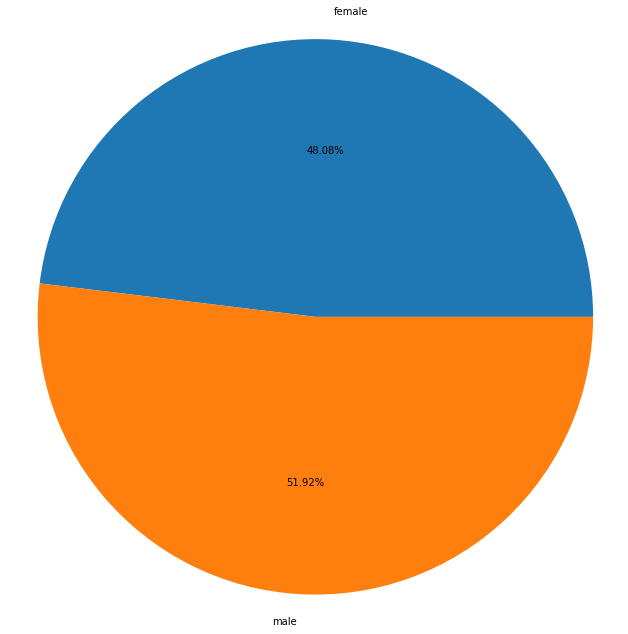

In [77]:
# pie plot
fig, ax = plt.subplots(figsize=(11,11))
order = pd.DataFrame()
order['age'] = gender['sex'].unique()
size = list(gender.loc[gender['date'] == '2020-05-14', 'deceased'])
order['size'] = size
order = order.sort_values(by=['size'])

ax.pie(order['size'], labels=order['age'], autopct='%.2f%%')
plt.axis('equal')

分析結果：死亡率2者相差不大，性別與死亡率無關。

**累積變動趨勢**

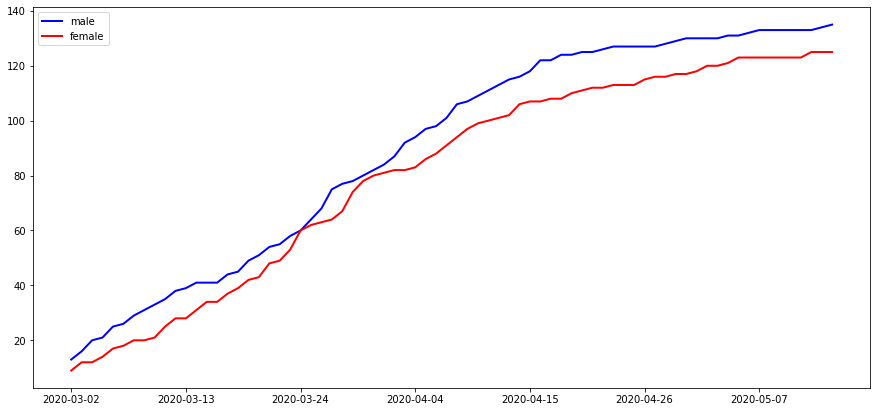

In [78]:
fig, ax = plt.subplots(figsize=(15,7))

# 連續圖
ax.plot(gender.date.unique(), gender.loc[gender['sex'] == 'male', 'deceased'], color = 'blue', linewidth = 2, label='male')
ax.plot(gender.date.unique(), gender.loc[gender['sex'] == 'female', 'deceased'], color = 'red', linewidth = 2, label='female')
plt.legend(loc='upper left')
ax.set_xticks(ax.get_xticks()[::11])

分析結果：男女累計死亡數，女性較男性高原因可能與女性確診人數較多有關。

**每日變動趨勢**

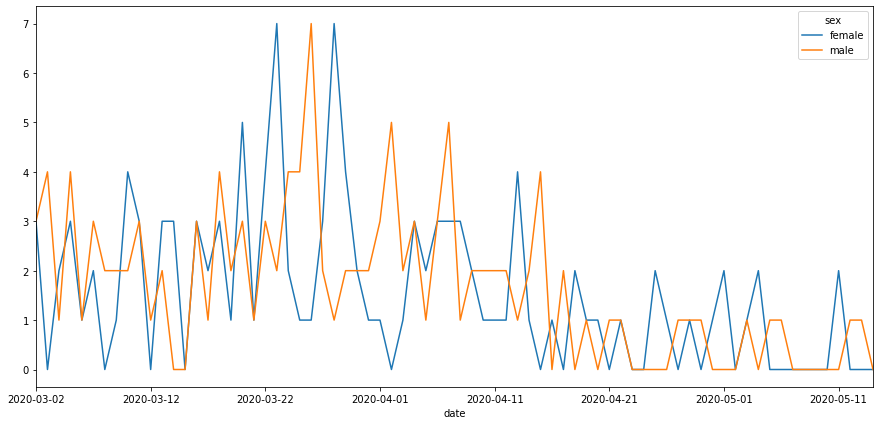

In [79]:
# daily deceased
for title in gender['sex'].unique():
    day = gender.loc[gender['sex']==title, 'deceased']
    gender.loc[gender['sex']==title, 'daily_deceased'] = day.shift(-1) - day

gender.groupby(['date','sex'])['daily_deceased'].sum() .unstack('sex', fill_value=0).plot(legend=True, figsize=(15,7))

分析結果：男女齊高或一高一低的情況都有，難以看出規律性。只有再次顯示出末段男性病患普遍比較多，因此也較容易死亡的特性。

## 2-2 年齡層面之分析 

### 不同年齡層確診率之比較(統計至2020-05-14)

**分布比例**

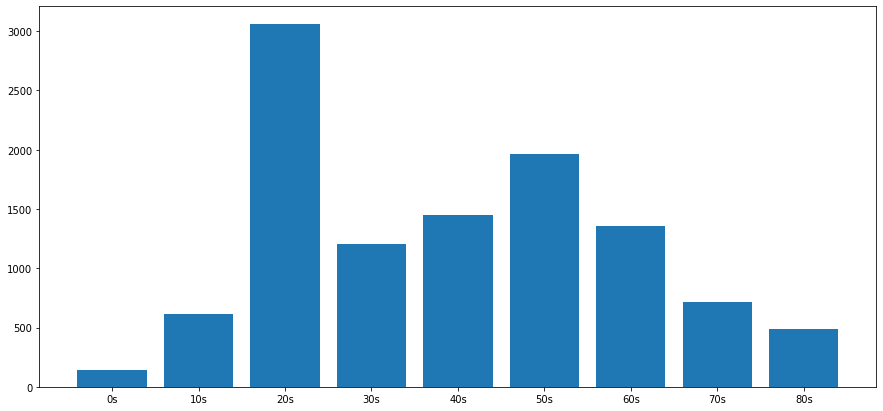

In [80]:
fig, ax = plt.subplots(figsize=(15,7))
bar = ax.bar(age['age'], age['confirmed'])

(-1.1100441190143997,
 1.100478296757703,
 -1.1109708543184509,
 1.1073780548094794)

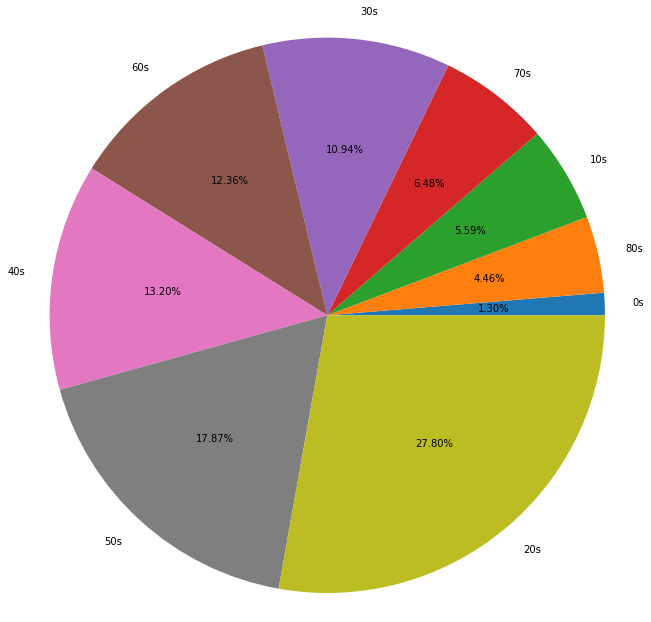

In [81]:
# pie plot
fig, ax = plt.subplots(figsize=(11,11))
order = pd.DataFrame()
order['age'] = age['age'].unique()
size = list(age.loc[age['date'] == '2020-05-14', 'confirmed'])
order['size'] = size
order = order.sort_values(by=['size'])

ax.pie(order['size'], labels=order['age'], autopct='%.2f%%')
plt.axis('equal')

分析結果：老人意外的並不是確診數最多的族群，儘管他們被認為免疫力比較差。而在20歲到30歲的年輕人發現更多的病原體。可能是因為年輕人比起老人，比較常到外面四處遊走，因些在這個疾病的高傳染力下有比較多的確診族群。也可能與生活習慣息息相關。

**累積變動趨勢**

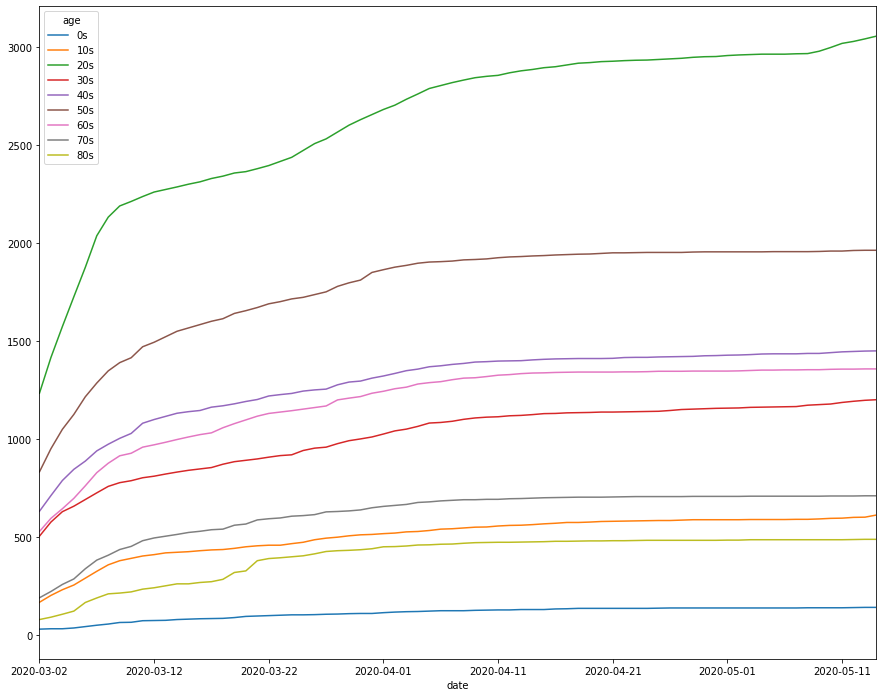

In [82]:
# 連續圖
# plot with each age
age.groupby(['date','age'])['confirmed'].sum() .unstack('age', fill_value=0).plot(legend=True, figsize=(15,12))

分析結果：老年人或是年紀比較小的兒童的趨勢比較平緩，可能與相對確診數較少有關。我們可以看出確診出越多變化也越激烈的傾向。

**每日變動趨勢**

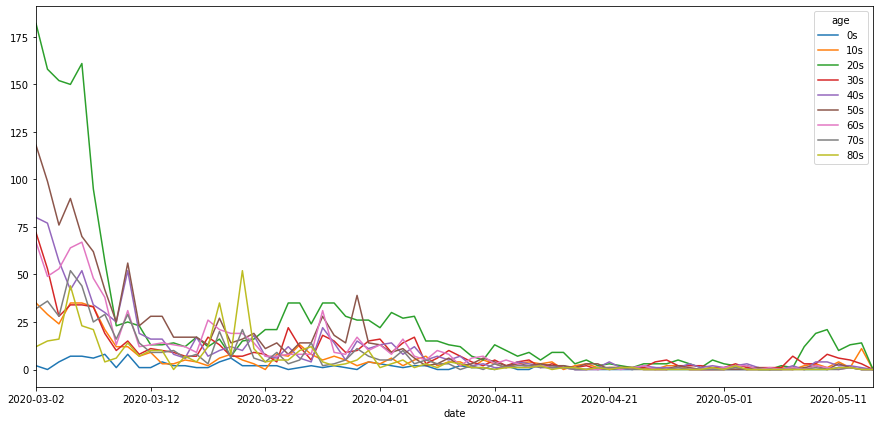

In [83]:
# daily confirmed
for title in age['age'].unique():
    day = age.loc[age['age']==title, 'confirmed']
    age.loc[age['age']==title, 'daily_confirmed'] = day.shift(-1) - day

age.groupby(['date','age'])['daily_confirmed'].sum() .unstack('age', fill_value=0).plot(legend=True, figsize=(15,7))

分析結果：幾乎都是20s族群爆發，可能年輕人活動範圍較廣泛。

**增長速率（以20歲為例）**

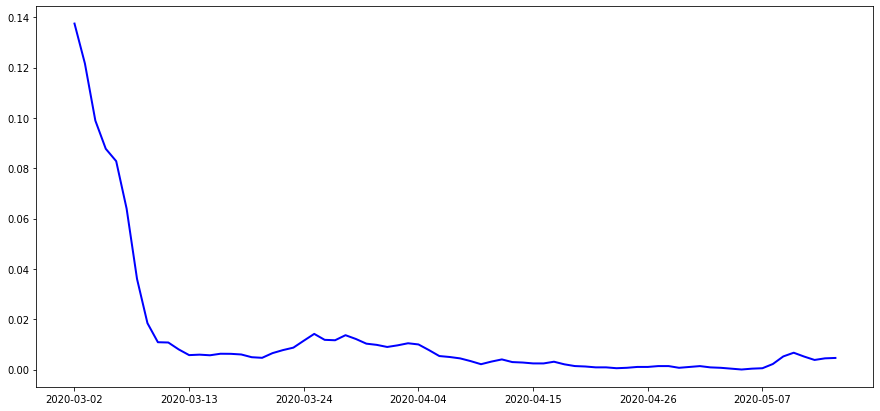

In [84]:
# 20s confirmed GrowthRate(logistic function)
age.loc[age['age']=='20s', 'GrowthRate']=np.gradient(np.log(age.loc[age['age']=='20s', 'confirmed']))
fig, ax = plt.subplots(figsize=(15,7))
ax.plot(age.date.unique(), age.loc[age['age']=='20s', 'GrowthRate'], color = 'blue', linewidth = 2, label='20s')
ax.set_xticks(ax.get_xticks()[::11])

分析結果：由於人數最多的20歲到30歲最具有代表性，這邊以他們的成長速率來象徵疫情的衰退程度。

### 不同年齡層死亡率之比較(統計至2020-05-14)

**分布比例**

(-1.1120580421091375,
 1.1005741924813874,
 -1.1148279318513958,
 1.1132247495111545)

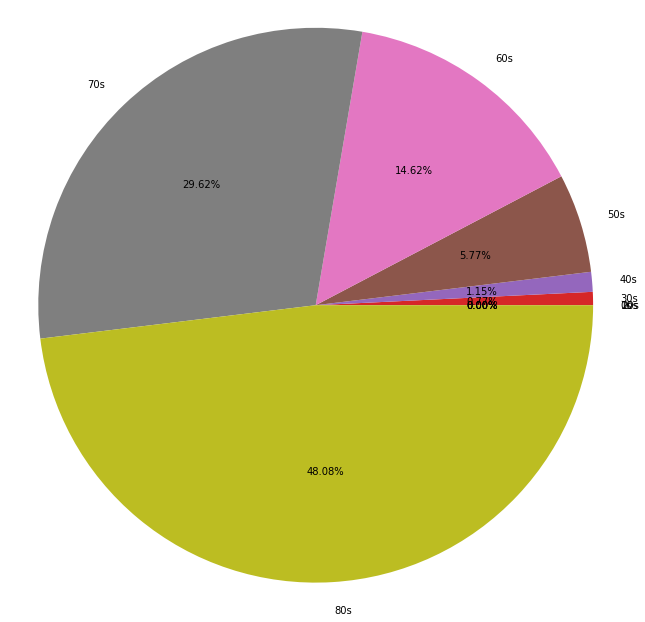

In [85]:
# pie plot
fig, ax = plt.subplots(figsize=(11,11))
order = pd.DataFrame()
order['age'] = age['age'].unique()
size = list(age.loc[age['date'] == '2020-05-14', 'deceased'])
order['size'] = size
order = order.sort_values(by=['size'])

ax.pie(order['size'], labels=order['age'], autopct='%.2f%%')
plt.axis('equal')

分析結果：老年人就佔了死亡人口的百分之七十，而年輕人確診數雖多，卻因為免疫力強的關係死亡率較低。綜合二者可推斷新冠肺炎是一種有高傳染力且對免疫力不好的人有嚴重威脅的疾病。

**累積變動趨勢**

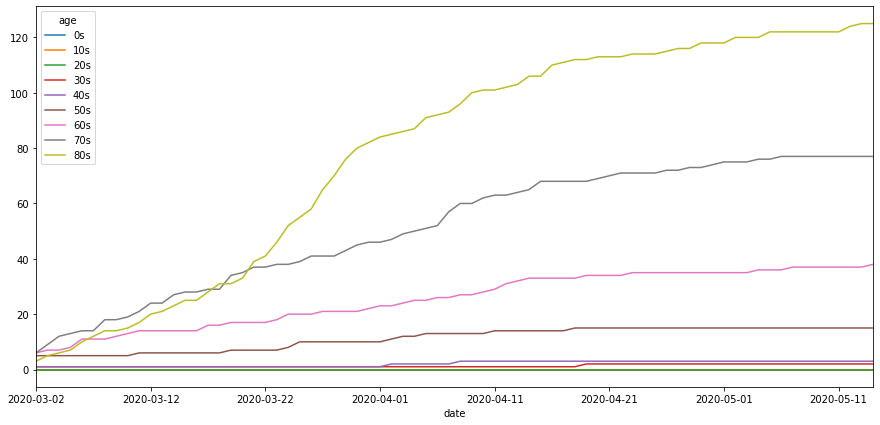

In [86]:
# 連續圖
# plot with each age
age.groupby(['date','age'])['deceased'].sum() .unstack('age', fill_value=0).plot(legend=True, figsize=(15,7))

分析結果：年紀越大死亡率越高。

**每日變動趨勢**

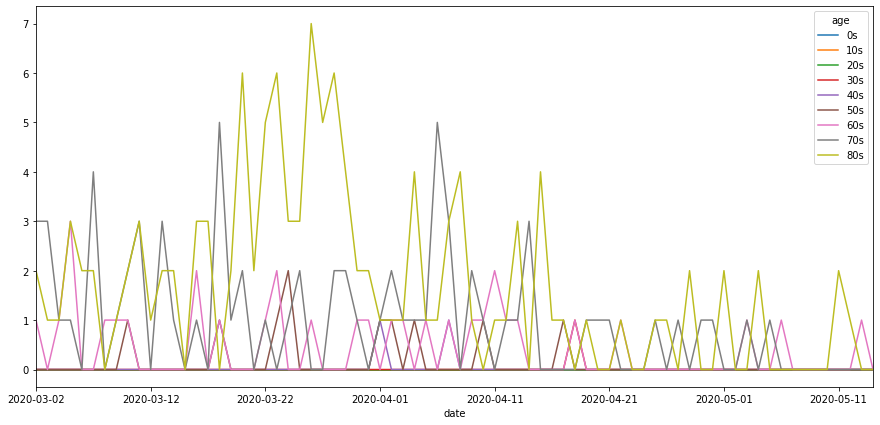

In [87]:

# daily deceased
for title in age['age'].unique():
    day = age.loc[age['age']==title, 'deceased']
    age.loc[age['age']==title, 'daily_deceased'] = day.shift(-1) - day

age.groupby(['date','age'])['daily_deceased'].sum() .unstack('age', fill_value=0).plot(legend=True, figsize=(15,7))

分析結果：3月22號到4月1號這段期間80歲左右的老人死亡數非常明顯的高於其它。而在前面的確診的圖的前幾天也可以發現其來到了峰值。這會是一個值得標註的事件。

### 2-3 浮動人口分析（以首爾為例）

In [88]:
df_float = pd.read_csv(datasets[9])
display(df_float.head(5).append(df_float.tail(5)))

,date,hour,birth_year,sex,province,city,fp_num
0,2020-01-01,0,20,female,Seoul,Dobong-gu,19140
1,2020-01-01,0,20,male,Seoul,Dobong-gu,19950
2,2020-01-01,0,20,female,Seoul,Dongdaemun-gu,25450
3,2020-01-01,0,20,male,Seoul,Dongdaemun-gu,27050
4,2020-01-01,0,20,female,Seoul,Dongjag-gu,28880
863995,2020-04-30,22,40,female,Seoul,Seongdong-gu,22150
863996,2020-04-30,22,50,female,Seoul,Seodaemun-gu,23270
863997,2020-04-30,23,20,female,Seoul,Yongsan-gu,18570
863998,2020-04-30,23,30,female,Seoul,Seodaemun-gu,21100
863999,2020-04-30,23,40,male,Seoul,Gangnam-gu,45730


### 基本調查與修正

**每日變動趨勢**

In [89]:
span_table = df_float.groupby(['date', 'hour']).sum()
display(span_table.head(5).append(span_table.tail(5))[['fp_num']])
date_average = span_table.groupby(['date']).mean()
date_average['fp_num'] = date_average['fp_num'].apply(lambda x: x / 1000000)
display(date_average.head(5).append(date_average.tail(5))[['fp_num']])


fp_num
date       hour         
2020-01-01 0     8131460
           1     8068010
           2     8030150
           3     7997210
           4     7969800
2020-04-30 19    7727190
           20    7758760
           21    7770910
           22    7756420
           23    7731390

,fp_num
date,
2020-01-01,8.016924
2020-01-02,8.455390
2020-01-03,8.472381
2020-01-04,8.224835
2020-01-05,8.156153
2020-04-26,7.881628
2020-04-27,8.299862
2020-04-28,8.295024
2020-04-29,8.270830


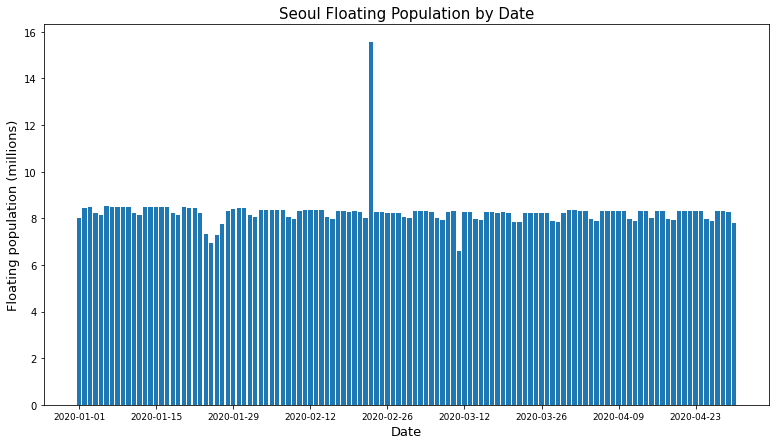

In [90]:


fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Seoul Floating Population by Date', size=15)
plt.bar(df_float.date.unique()
       , date_average.fp_num.values)
ax.set_xlabel('Date', size=13)
ax.set_ylabel('Floating population (millions)', size=13)
plt.xticks(rotation=0, size=9)
ax.set_xticks(ax.get_xticks()[::14])
plt.show()

分析結果：從上面的柱狀圖我們可以觀察到首爾每日浮動人口波動的情形，並以兩週作為刻度。大約是一月二十七日的左右有一個下陷，可以解釋成韓國也有春節的活動，返鄉潮的關係讓非永久住民減少。其它的時段大致上都還算平穩，唯有約莫在二月二十幾號的時候出現了明顯不合理的異常值。若不是有什麼重大事件發生那就是資料有誤。下面將針對這點進行分析，並決定是要探索出意義或是試著將其修正。

**觀察異常值**

In [91]:
outlier = date_average[date_average['fp_num'] >= 12]
display(outlier)
print(f'異常日期：{outlier.index[0]}')

,birth_year,fp_num
date,,
2020-02-23,13500.0,15.545315


異常日期：2020-02-23


,birth_year,fp_num
hour,,
0,0.0135,15.86466
1,0.0135,15.83910
2,0.0135,15.80694
3,0.0135,15.76398
4,0.0135,15.72644
5,0.0135,15.69123
6,0.0135,15.65973
7,0.0135,15.66723
8,0.0135,15.73829


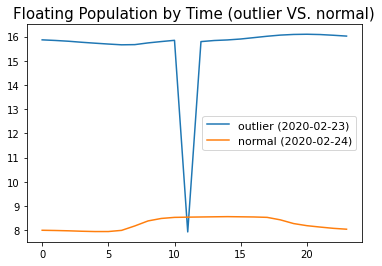

In [92]:
error_table = span_table.loc['2020-02-23'] / 1000000
display(error_table)

plt.title('Floating Population by Time (outlier VS. normal)', size=15)
outlier = error_table.fp_num
                                                    
normal_table = span_table.loc['2020-02-24'] / 1000000
normal = normal_table.fp_num

plt.plot(outlier)
plt.plot(normal)
ax.set_xlabel('Hour of day', size=13)
ax.set_ylabel('Floating population (millions)', size=13)
plt.legend(['outlier (2020-02-23)', 'normal (2020-02-24)'], fontsize=11, loc='center right')
plt.show()

分析結果：查出發生異常的日期是2月23日後，我們觀察他與隔一天每小時浮動人口的變化，結果發現2月23日唯一與其它不同的量值與看起來比較正常的翌日相差無幾。再透過上面的表格，我們可以大膽的假設除了11點是正確的，其它值都被錯誤的放大了兩倍。必須進行修正，否則其它的分析將受到干擾。

**異常值修正**

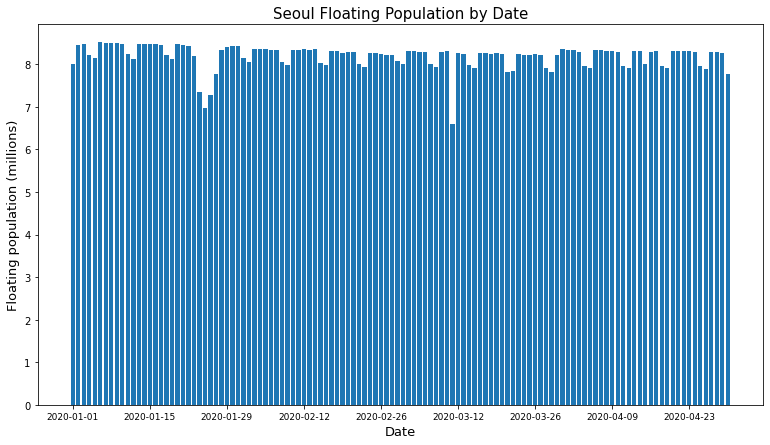

In [93]:
df_float.loc[(df_float.date=='2020-02-23') & (df_float.hour!=11), 'fp_num' ] /= 2
span_table = df_float.groupby(['date', 'hour']).sum()
date_average = span_table.groupby(['date']).mean()
date_average['fp_num'] = date_average['fp_num'].apply(lambda x: x / 1000000)

fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Seoul Floating Population by Date', size=15)
plt.bar(df_float.date.unique()
       , date_average.fp_num.values)
ax.set_xlabel('Date', size=13)
ax.set_ylabel('Floating population (millions)', size=13)
plt.xticks(rotation=0, size=9)
ax.set_xticks(ax.get_xticks()[::14])
plt.show()

,birth_year,fp_num
hour,,
0,0.0135,7.932330
1,0.0135,7.919550
2,0.0135,7.903470
3,0.0135,7.881990
4,0.0135,7.863220
5,0.0135,7.845615
6,0.0135,7.829865
7,0.0135,7.833615
8,0.0135,7.869145


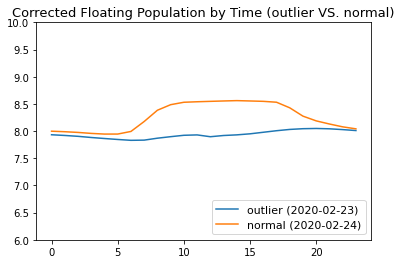

In [94]:
error_table = span_table.loc['2020-02-23'] / 1000000
display(error_table)

plt.title('Corrected Floating Population by Time (outlier VS. normal)', size=13)
outlier = error_table.fp_num
                                                    
normal_table = span_table.loc['2020-02-24'] / 1000000
normal = normal_table.fp_num

plt.plot(outlier)
plt.plot(normal)
ax.set_xlabel('Hour of day', size=13)
ax.set_ylabel('Floating population (millions)', size=13)
plt.ylim(6, 10)
plt.legend(['outlier (2020-02-23)', 'normal (2020-02-24)'], fontsize=11, loc='lower right')
plt.show()

### 浮動人口組成調查與比較

**性別層面**

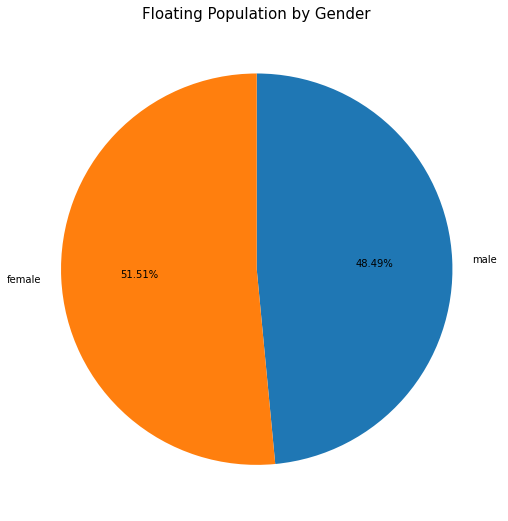

In [95]:
seoul_male = df_float[df_float.sex == 'male']
seoul_female = df_float[df_float.sex == 'female']

fig, ax = plt.subplots(figsize=(9, 9))
plt.title('Floating Population by Gender', size=15)
plt.pie([seoul_male.fp_num.sum()
         , seoul_female.fp_num.sum()]
        , labels=['male', 'female']
        , autopct='%.2f%%'
        , startangle=90
        , counterclock=False)
plt.show()


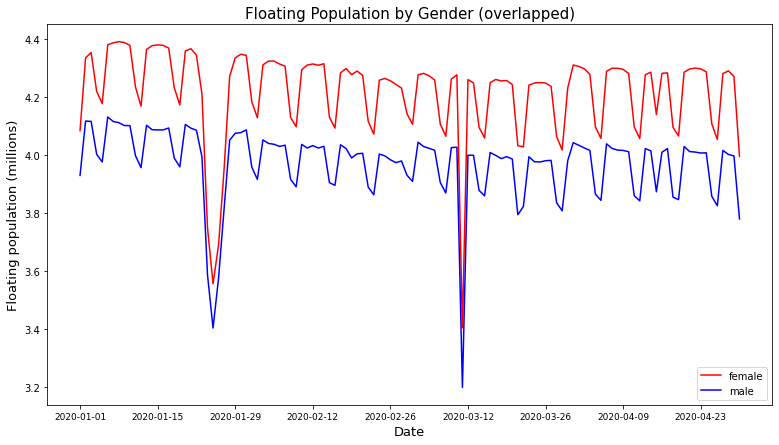

In [96]:
fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Floating Population by Gender (overlapped)', size=15)
colors = [(1,0,0),(0,0,1)]

for sex, i in zip([seoul_female, seoul_male], range(2)):
    sns.lineplot(sex.date.unique() , sex.groupby(['date', 'hour']).sum()\
        .groupby('date').mean().apply(lambda x: x/1000000)\
        .fp_num.values, color=colors[i])
ax.set_xlabel('Date', size=13)
ax.set_ylabel('Floating population (millions)', size=13)
plt.xticks(rotation=0, size=9)
plt.legend(['female', 'male'], loc='lower right')
ax.set_xticks(ax.get_xticks()[::14])
plt.show()

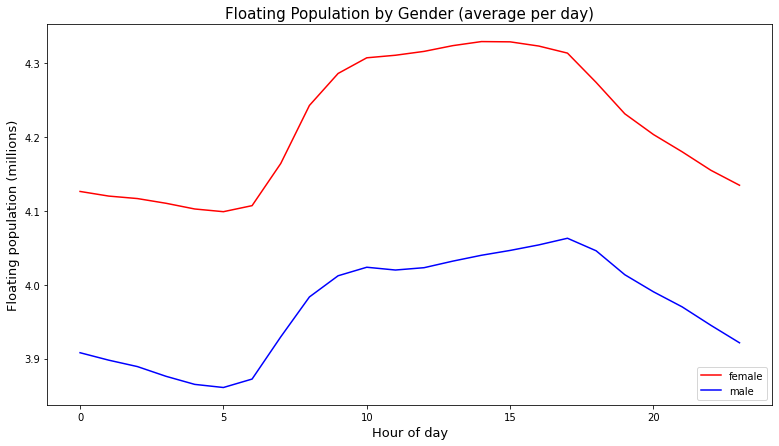

In [97]:
fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Floating Population by Gender (average per day)', size=15)
plt.plot(seoul_female.groupby(['date', 'hour']).sum()\
         .groupby('hour').mean().apply(lambda x: x/1000000)\
         .fp_num
         , color=colors[0])
plt.plot(seoul_male.groupby(['date', 'hour']).sum()\
         .groupby('hour').mean().apply(lambda x: x/1000000)\
         .fp_num
         , color=colors[1])
ax.set_ylabel('Floating population (millions)', size=13)
ax.set_xlabel('Hour of day', size=13)
plt.legend(['female', 'male'], loc='lower right')
plt.show()

分析結果：在性別的組成方面顯示出了浮動人口中女性無時無刻的高於男性的這個事實。與整體的分析結果一致。且一天之中的變動趨勢是差不多的（都是在上班時間達到高峰）。

**年齡層面**

,hour,fp_num
birth_year,,
30,1656000,4.804668e+09
40,1656000,4.797880e+09
50,1656000,4.495949e+09
20,1656000,4.297191e+09
60,1656000,2.950036e+09
70,1656000,2.233458e+09


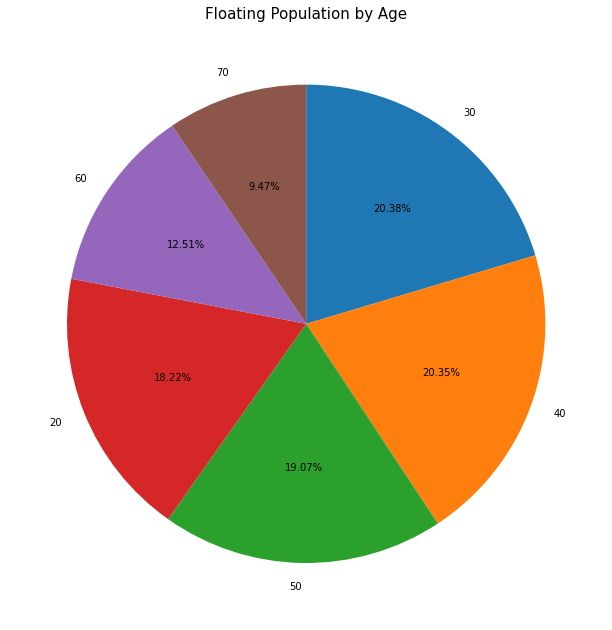

In [98]:
float_age_table = df_float.groupby('birth_year').sum().sort_values(by='fp_num',ascending=False)
float_age_order = list(float_age_table.index)
display(float_age_table)
fig, ax = plt.subplots(figsize=(11, 11))
plt.title('Floating Population by Age', size=15)
plt.pie(float_age_table.fp_num.values , labels=float_age_order , autopct='%.2f%%', startangle=90, counterclock=False)
plt.show()

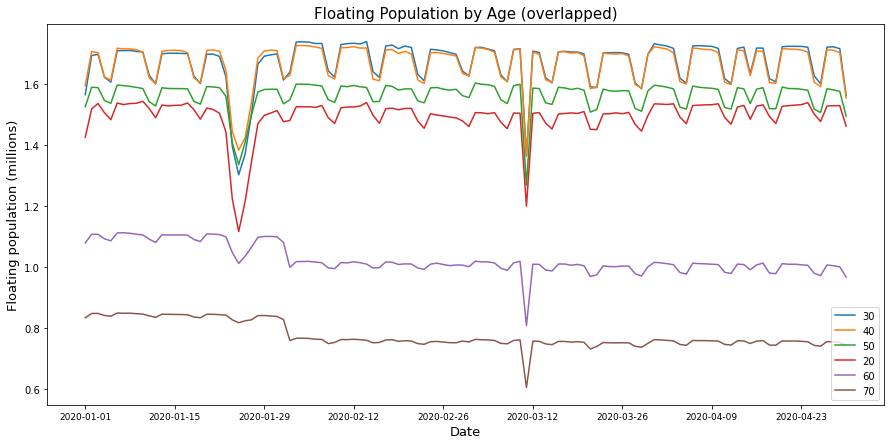

In [99]:
fig, ax = plt.subplots(figsize=(15, 7))
plt.title('Floating Population by Age (overlapped)', size=15)
for age, i in zip(float_age_order, range(len(float_age_order))):
    sns.lineplot(df_float.date.unique()
            , df_float[df_float.birth_year==age].groupby(['date', 'hour']).sum()\
            .groupby('date').mean().apply(lambda x: x/1000000)\
            .fp_num.values)
ax.set_xlabel('Date', size=13)
ax.set_ylabel('Floating population (millions)', size=13)
plt.xticks(rotation=0, size=9)
plt.legend(float_age_order
           , loc='lower right'
          )
ax.set_xticks(ax.get_xticks()[::14])
plt.show()

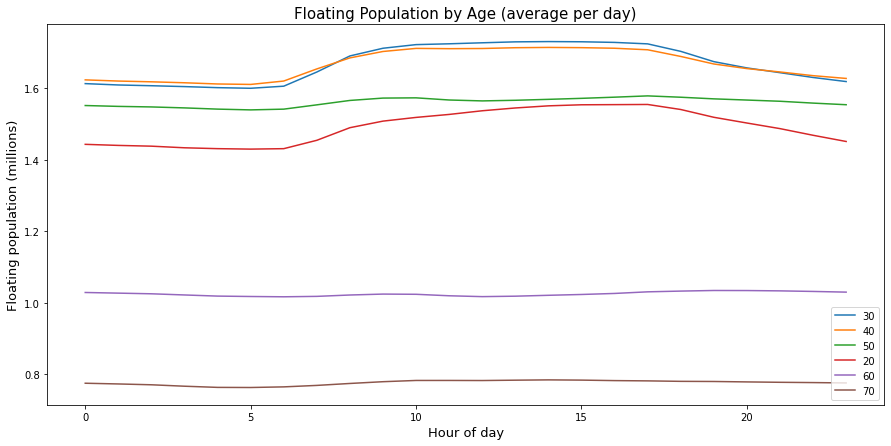

In [100]:
fig, ax = plt.subplots(figsize=(15, 7))
plt.title('Floating Population by Age (average per day)', size=15)

for age, i in zip(float_age_order, range(len(float_age_order))):
    sns.lineplot(df_float.hour.unique()
            , df_float[df_float.birth_year==age].groupby(['date', 'hour']).sum()\
            .groupby('hour').mean().apply(lambda x: x/1000000)\
            .fp_num)

ax.set_ylabel('Floating population (millions)', size=13)
ax.set_xlabel('Hour of day', size=13)
plt.legend(float_age_order, loc='lower right')
plt.show()

分析結果：由年齡組成有關的圖可以斷定首爾浮動人口的年輕人主要的主成份子是工作人口。原因是1/27號左右男女的下降都比較一致，而這一天中老年人(60歲+70歲)的波動幅度卻不如其他年齡的來得大。而一天的變動趨勢中，工作時段的年輕組有微微上揚，而老年組則一天的變化都很穩定。

**子區域層面**

In [101]:
float_area_table = df_float.groupby('city').sum().sort_values('fp_num', ascending=False)
float_area_table['ratio'] = float_area_table.fp_num.apply(lambda x: x / (df_float.fp_num.sum()) * 100)
display(float_area_table)
float_area_order = list(float_area_table.index)


,hour,birth_year,fp_num,ratio
city,,,,
Gangnam-gu,397440,1555200,1.684455e+09,7.143822
Songpa-gu,397440,1555200,1.489581e+09,6.317355
Gangseo-gu,397440,1555200,1.268894e+09,5.381415
Seocho-gu,397440,1555200,1.177264e+09,4.992813
Nowon-gu,397440,1555200,1.139016e+09,4.830599
Gwanak-gu,397440,1555200,1.131892e+09,4.800385
Yeongdeungpo-gu,397440,1555200,1.130382e+09,4.793982
Guro-gu,397440,1555200,1.017553e+09,4.315471
Mapo-gu,397440,1555200,9.744652e+08,4.132735


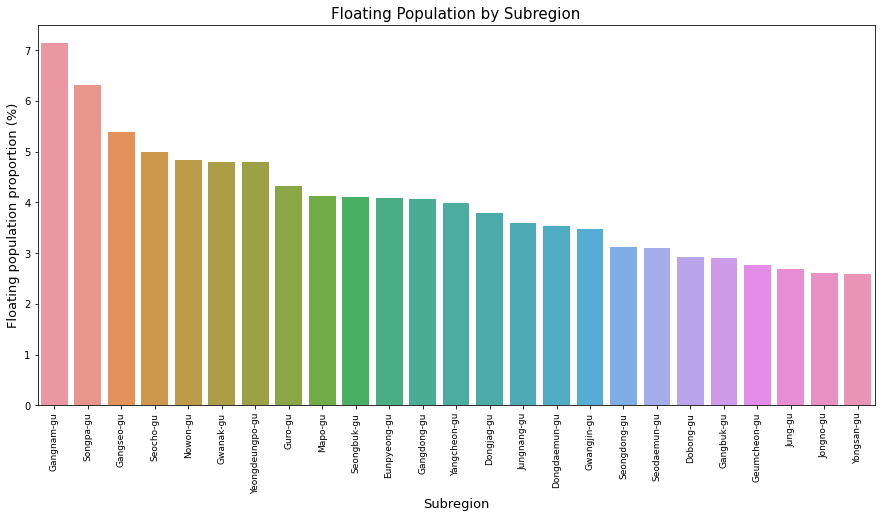

In [102]:
fig, ax = plt.subplots(figsize=(15, 7))
plt.title('Floating Population by Subregion', size=15)
sns.barplot(float_area_order
           , float_area_table['ratio'])
ax.set_xlabel('Subregion', size=13)
ax.set_ylabel('Floating population proportion (%)', size=13)
plt.xticks(rotation=90, size=9)
plt.show()

分析結果：從這張圖看不出什麼，因此我們引入外部資料，探討各子區域人口以及確診數的關係。截至(4/27日)的各子區域的累績確認數來自於
Seoul COVID-19[http://www.seoul.go.kr/coronaV/coronaStatus.do]

**子區域人口與確診數之關聯性**

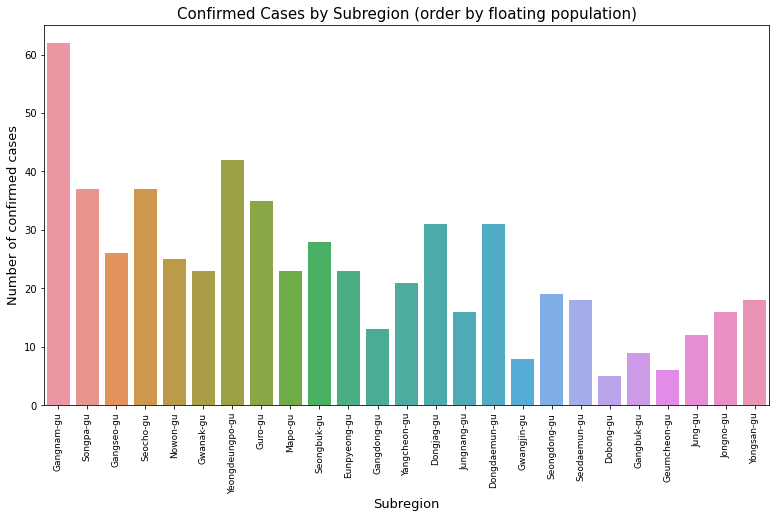

In [103]:
seoul_confirmed = [62, 37, 26, 37, 25
                   , 23, 42, 35, 23, 28
                   , 23, 13, 21, 31, 16
                   , 31, 8, 19, 18, 5
                   , 9, 6, 12, 16, 18]

fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Confirmed Cases by Subregion (order by floating population)', size=15)
sns.barplot(float_area_order
           , seoul_confirmed)
ax.set_xlabel('Subregion', size=13)
ax.set_ylabel('Number of confirmed cases', size=13)
plt.xticks(rotation=90, size=9)
plt.show()

分析結果：圖形大致成正相關，即人口數越多確診案例也就越多。

### 變動量分析

**浮動人口之變化量**

首先將浮動人口變化量以及全部的每日確診變化量標準化，畫出變化趨勢並加以疊圖，觀察首爾市浮動人口的變化對於整體是否有指標性的意義。

In [104]:
date_average = date_average[19:]
display(date_average)

,birth_year,fp_num
date,,
2020-01-20,13500,8.467384
2020-01-21,13500,8.462307
2020-01-22,13500,8.432982
2020-01-23,13500,8.206383
2020-01-24,13500,7.338105
...,...,...
2020-04-26,13500,7.881628
2020-04-27,13500,8.299862
2020-04-28,13500,8.295024


In [105]:

date_average = span_table.groupby(['date']).mean()[19:]
data_average_describe = date_average.describe()
display(data_average_describe)
std = data_average_describe.at['std','fp_num']
mean = data_average_describe.at['mean','fp_num']
date_average['std_fp_num'] = date_average['fp_num'].apply(lambda x : (x - mean) / std)
display(date_average)

,birth_year,fp_num
count,101.0,1.010000e+02
mean,13500.0,8.154222e+06
std,0.0,2.913612e+05
min,13500.0,6.605008e+06
25%,13500.0,8.015516e+06
50%,13500.0,8.264199e+06
75%,13500.0,8.318963e+06
max,13500.0,8.467384e+06


,birth_year,fp_num,std_fp_num
date,,,
2020-01-20,13500,8.467384e+06,1.074824
2020-01-21,13500,8.462307e+06,1.057397
2020-01-22,13500,8.432982e+06,0.956752
2020-01-23,13500,8.206383e+06,0.179024
2020-01-24,13500,7.338105e+06,-2.801051
...,...,...,...
2020-04-26,13500,7.881628e+06,-0.935589
2020-04-27,13500,8.299862e+06,0.499862
2020-04-28,13500,8.295024e+06,0.483254


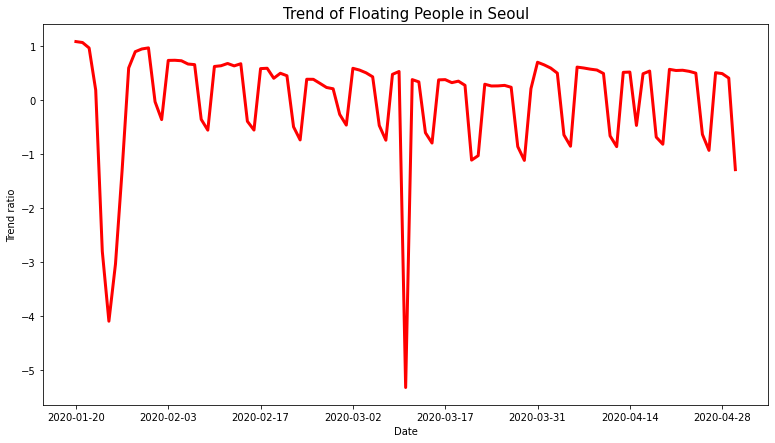

In [106]:
fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Trend of Floating People in Seoul', size=15)
plt.plot(date_average.index.unique(), date_average.std_fp_num
         , color='red'
         , lw=3)
ax.set_xticks(ax.get_xticks()[::14])
plt.xlabel('Date')
plt.ylabel('Trend ratio')
plt.show()

分析結果：從趨勢圖可以更好的看見浮動人口的變化。除了兩個特殊事件外，大致是以七天為一個週期，在假日時進入波谷而在工作日回到大致算穩定的波峰。

**與整體確診趨勢圖之疊圖**

In [107]:
df_time = pd.read_csv(datasets[4])
df_float_time = df_time[:-14]
display(df_float_time.head(5).append(df_float_time.tail(5)))

,date,time,test,negative,confirmed,released,deceased
0,2020-01-20,16,1,0,1,0,0
1,2020-01-21,16,1,0,1,0,0
2,2020-01-22,16,4,3,1,0,0
3,2020-01-23,16,22,21,1,0,0
4,2020-01-24,16,27,25,2,0,0
97,2020-04-26,0,598285,578558,10728,8717,242
98,2020-04-27,0,601660,582027,10738,8764,243
99,2020-04-28,0,608514,588559,10752,8854,244
100,2020-04-29,0,614197,595129,10761,8922,246
101,2020-04-30,0,619881,600482,10765,9059,247


In [108]:
#計算每日新增確診數
for index, row in df_float_time.iterrows():
    
    if index == 0:
        df_float_time.at[index,'new_confirmed'] = 1
    else:
        df_float_time.at[index,'new_confirmed'] = df_float_time.at[index,'confirmed'] - df_float_time.at[index - 1,'confirmed']
display(df_float_time.head(5).append(df_float_time.tail(5)))

,date,time,test,negative,confirmed,released,deceased,new_confirmed
0,2020-01-20,16,1,0,1,0,0,1.0
1,2020-01-21,16,1,0,1,0,0,0.0
2,2020-01-22,16,4,3,1,0,0,0.0
3,2020-01-23,16,22,21,1,0,0,0.0
4,2020-01-24,16,27,25,2,0,0,1.0
97,2020-04-26,0,598285,578558,10728,8717,242,10.0
98,2020-04-27,0,601660,582027,10738,8764,243,10.0
99,2020-04-28,0,608514,588559,10752,8854,244,14.0
100,2020-04-29,0,614197,595129,10761,8922,246,9.0
101,2020-04-30,0,619881,600482,10765,9059,247,4.0


In [109]:
#正規化每日新增確診數
new_confirmed_describe = df_float_time['new_confirmed'].describe()
display(new_confirmed_describe)
mean = (new_confirmed_describe.loc['mean'])
std = (new_confirmed_describe.loc['std'])
df_float_time['std_new_confirmed'] = df_float_time['new_confirmed'].apply(lambda x : (x - mean) / std)
display(df_float_time.head(5).append(df_float_time.tail(5)))

count    102.000000
mean     105.539216
std      166.330023
min        0.000000
25%        2.250000
50%       31.000000
75%      109.250000
max      813.000000
Name: new_confirmed, dtype: float64

,date,time,test,negative,confirmed,released,deceased,new_confirmed,std_new_confirmed
0,2020-01-20,16,1,0,1,0,0,1.0,-0.628505
1,2020-01-21,16,1,0,1,0,0,0.0,-0.634517
2,2020-01-22,16,4,3,1,0,0,0.0,-0.634517
3,2020-01-23,16,22,21,1,0,0,0.0,-0.634517
4,2020-01-24,16,27,25,2,0,0,1.0,-0.628505
97,2020-04-26,0,598285,578558,10728,8717,242,10.0,-0.574395
98,2020-04-27,0,601660,582027,10738,8764,243,10.0,-0.574395
99,2020-04-28,0,608514,588559,10752,8854,244,14.0,-0.550347
100,2020-04-29,0,614197,595129,10761,8922,246,9.0,-0.580408
101,2020-04-30,0,619881,600482,10765,9059,247,4.0,-0.610468


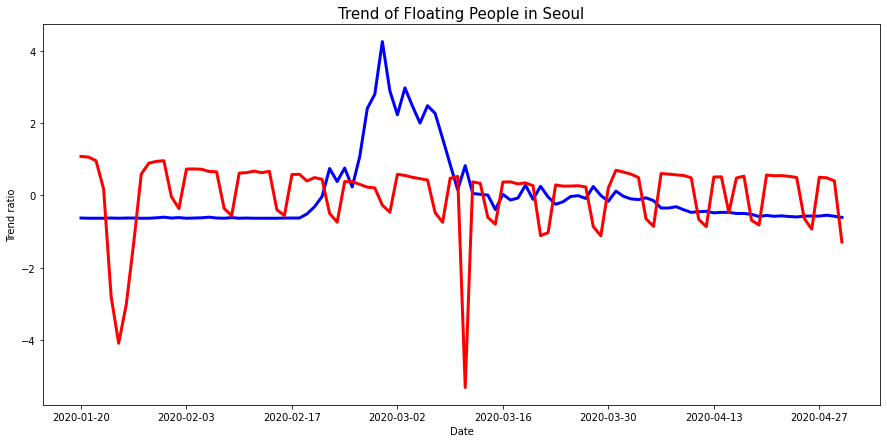

In [110]:
fig, ax = plt.subplots(figsize=(15, 7))
plt.title('Trend of Floating People in Seoul', size=15)
plt.plot(df_float_time['date'], df_float_time['std_new_confirmed']
         , color='blue'
         , lw=3)
plt.plot(date_average.index.unique(), date_average.std_fp_num
         , color='red'
         , lw=3)
ax.set_xticks(ax.get_xticks()[::14])
plt.xlabel('Date')
plt.ylabel('Trend ratio')
plt.show()

分析結果：將兩張趨勢圖進行疊圖後，大致可看出浮動人口的變化與確認數的變化基本上沒有關聯，浮動人口是按照它自己的週期在跳動了，只除了一點。3月10日那時候浮動人口急遽的下降，剛好是疫情的大爆發波峰剛過之際。推測是那時候首爾的情況也十分嚴重，人心惶惶造成浮動人口消退。

# PartIII 其它分析與未來確診數之預測
-----------------------------------
   ## 使用的資料集：
   
   
  ### Policy
  資料集說明：

- policy_id: 該項政策的流水編號
- type: 該項政策的類型
- gov_policy: 政策的粗略介紹
- detail: 政策的細節
- start_date: 該項政策啟用的時間
- end_date: 該項政策被廢止的時間
 
 
  ## 主要分析法：
 - 從政府對疫情的對應，從側面觀察當時疫情的嚴重性

### 3-1 政策層面分析

**基本調查**

In [111]:
display(policy.head(5).append(policy.tail(5)))

,policy_id,country,type,gov_policy,detail,start_date,end_date
0,1,Korea,Alert,Infectious Disease Alert Level,Level 1 (Blue),2020-01-03,2020-01-19
1,2,Korea,Alert,Infectious Disease Alert Level,Level 2 (Yellow),2020-01-20,2020-01-27
2,3,Korea,Alert,Infectious Disease Alert Level,Level 3 (Orange),2020-01-28,2020-02-22
3,4,Korea,Alert,Infectious Disease Alert Level,Level 4 (Red),2020-02-23,NaN
4,5,Korea,Immigration,Special Immigration Procedure,from China,2020-02-04,NaN
48,49,Korea,Technology,Open API,Public Mask Sales Information,2020-03-08,NaN
49,50,Korea,Technology,Self-Diagnosis App,NaN,2020-02-12,NaN
50,51,Korea,Technology,Self-Quarantine Safety Protection App,NaN,2020-03-07,NaN
51,52,Korea,Technology,Electronic Wristbands,on people who violate self-quarantine measures,2020-04-27,NaN
52,53,Korea,Administrative,Close bars and clubs,administrative order to close bars and clubs,2020-05-08,2020-06-07


In [112]:

#統計每則政令發布日期
policy_num = pd.DataFrame()
count = policy.groupby('start_date').count()
display(count.policy_id)

start_date
2020-01-03    1
2020-01-20    2
2020-01-28    1
2020-02-04    2
2020-02-12    4
2020-02-23    1
2020-02-26    1
2020-02-27    3
2020-03-02    5
2020-03-04    1
2020-03-07    1
2020-03-08    1
2020-03-09    2
2020-03-12    2
2020-03-13    1
2020-03-15    5
2020-03-16    1
2020-03-19    1
2020-03-22    1
2020-04-01    1
2020-04-06    1
2020-04-09    2
2020-04-13    1
2020-04-16    7
2020-04-20    3
2020-04-27    1
2020-05-08    1
Name: policy_id, dtype: int64

分析結果：有多項現今仍沿用的政策，並且韓國政府最早從1月3日作出對應。4月16號時出現了異常值，標誌著大事件的發生。

**分布**

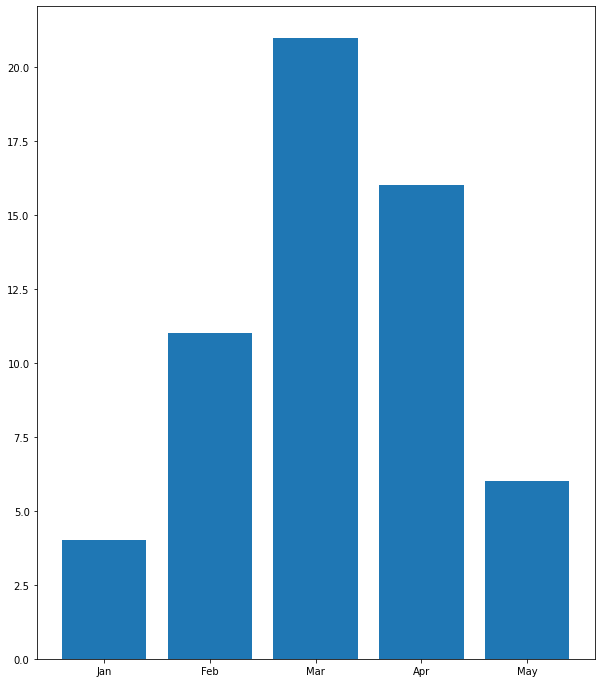

In [113]:
fig, ax = plt.subplots(figsize=(10,12))
month=['Jan','Feb','Mar','Apr','May']
policy_count=[4,11,21,16,6]
bar = ax.bar(month, policy_count)

分析結果：上圖中可看出政令發布數量最高的3,4月，是韓國疫情的高峰，推測政令發布頻率與疫情嚴重程度相關。

### 3-2 數值性預測

分析結果：待補

# PartIV 結論
-----------------------------------
  
  ## 哪些人容易得病：
   - 容易確診：20歲到30歲的年輕人。女性。位於大邱及京畿道地區的居民。
   - 容易死亡：老人
   - 不容易確診： 幼兒及老人，住在偏鄉下地區的人。人口數越少越不容易確診。
   - 不容易死亡： 年輕人、幼兒
  
     
  ## 與疫情息息相關的因素：
   - 群聚事件（新天地）
   - 政府的政策發佈的數量
  
  
  ## 整體趨勢：
   - 3、4月是疫情高峰
   - 疫情已平緩
   
   
  ## 參考資料：
   - http://index.go.kr/potal/main/EachDtlPageDetail.do?idx_cd=1007
   - http://www.seoul.go.kr/coronaV/coronaStatus.do
   - http://www.koreaherald.com/view.php?ud=20191119000682
   - https://www.kaggle.com/dkjung/covid-19-eda-s-korea-forecasting-global
     
   
  